<a href="https://colab.research.google.com/github/KVasq/dwr_detection/blob/main/dwr_cnn_rnn_all5yrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Original Model


In [ ]:
import torch
from torch.nn.functional import conv1d
from torch import nn, optim

# Define Model
class inverse_model(nn.Module):
    # initialize with variables in_channels, resolution_ratio, and nonlinearity
    def __init__(self, in_channels,resolution_ratio=6,nonlinearity="tanh"): 
        super(inverse_model, self).__init__()
        self.in_channels = in_channels
        self.resolution_ratio = resolution_ratio # vertical scale mismtach between seismic and EI
        self.activation =  nn.ReLU() if nonlinearity=="relu" else nn.Tanh()

        # local pattern analysis submodule:  extracts local attributes from seismic traces that best model high-frequency trends of EI trace
        self.cnn1 = nn.Sequential(nn.Conv1d(in_channels=self.in_channels,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=2,
                                           dilation=1),
                                  nn.GroupNorm(num_groups=self.in_channels,
                                               num_channels=8))

        self.cnn2 = nn.Sequential(nn.Conv1d(in_channels=self.in_channels,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=6,
                                           dilation=3),
                                  nn.GroupNorm(num_groups=self.in_channels,
                                               num_channels=8))

        self.cnn3 = nn.Sequential(nn.Conv1d(in_channels=self.in_channels,
                                           out_channels=8,
                                           kernel_size=5,
                                           padding=12,
                                           dilation=6),
                                  nn.GroupNorm(num_groups=self.in_channels,
                                               num_channels=8))

        self.cnn = nn.Sequential(self.activation,
                                 nn.Conv1d(in_channels=24,
                                           out_channels=16,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=self.in_channels,
                                              num_channels=16),
                                 self.activation,

                                 nn.Conv1d(in_channels=16,
                                           out_channels=16,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=self.in_channels,
                                              num_channels=16),
                                 self.activation,

                                 nn.Conv1d(in_channels=16,
                                           out_channels=16,
                                           kernel_size=1),
                                 nn.GroupNorm(num_groups=self.in_channels,
                                              num_channels=16),
                                 self.activation)
        
        # sequence modeling submodule: models temporal dynamics of seismic traces and produces features that best represent the low-frequency content of EI
        self.gru = nn.GRU(input_size=self.in_channels,
                          hidden_size=8,
                          num_layers=3,
                          batch_first=True,
                          bidirectional=True)
        
        # upscaling submodule: takes the sum of the features produced by the previous modules and upscales them vertically. 
        self.up = nn.Sequential(nn.ConvTranspose1d(in_channels=16,
                                                   out_channels=8,
                                                   stride=3,
                                                   kernel_size=5,
                                                   padding=1),
                                nn.GroupNorm(num_groups=self.in_channels,
                                             num_channels=8),
                                self.activation,

                                nn.ConvTranspose1d(in_channels=8,
                                                   out_channels=8,
                                                   stride=2,
                                                   kernel_size=4,
                                                   padding=1),
                                nn.GroupNorm(num_groups=self.in_channels,
                                             num_channels=8),
                                self.activation)
        
        # Regrssion submodule: role is to regress the extracted features from the other modules to the target domain (EI domain)
        self.gru_out = nn.GRU(input_size=8,
                              hidden_size=8,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)
        self.out = nn.Linear(in_features=16, out_features=self.in_channels)

        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                nn.init.xavier_uniform_(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, nn.GroupNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()


        self.optimizer = optim.Adam(self.parameters(), 0.005, weight_decay=1e-4)

    # specify how data will pass through the network 
    def forward(self, x):
        cnn_out1 = self.cnn1(x)
        cnn_out2 = self.cnn2(x)
        cnn_out3 = self.cnn3(x)
        cnn_out = self.cnn(torch.cat((cnn_out1,cnn_out2,cnn_out3),dim=1))

        tmp_x = x.transpose(-1, -2)
        rnn_out, _ = self.gru(tmp_x)
        rnn_out = rnn_out.transpose(-1, -2)

        x = rnn_out + cnn_out

        #upscaling
        x = self.up(x)

        #regrssion
        tmp_x = x.transpose(-1, -2)
        x, _ = self.gru_out(tmp_x)

        x = self.out(x)
        x = x.transpose(-1,-2)
        return x


class forward_model(nn.Module):
    def __init__(self, wavelet, resolution_ratio=6):
        super(forward_model, self).__init__()
        self.wavelet = wavelet.float() if torch.is_tensor(wavelet) else torch.tensor(wavelet).float()
        self.resolution_ratio = resolution_ratio
    def cuda(self):
        self.wavelet = self.wavelet.cuda()



    def forward(self, x):
        x_d = x[..., 1:] - x[..., :-1]
        x_a = (x[..., 1:] + x[..., :-1]) / 2

        rc = x_d / x_a
        for i in range(rc.shape[1]):
            tmp_synth = conv1d(rc[:, [i]], self.wavelet, padding=int(self.wavelet.shape[-1] / 2))

            if i == 0:
                synth = tmp_synth
            else:
                synth = torch.cat((synth, tmp_synth), dim=1)

        synth = synth[...,::self.resolution_ratio]

        return synth

## Util

In [ ]:
import numpy as np
import torch


#%% Normalization
class Normalization:
    def __init__(self, mean_val=None,std_val=None):
        self.mean_val = mean_val
        self.std_val = std_val

    def normalize(self, x):
        return (x-self.mean_val)/self.std_val

    def unnormalize(self, x):
        return x*self.std_val + self.mean_val


#%% Metrics
def metrics(y,x):
    #x: reference signal
    #y: estimated signal
    if torch.is_tensor(x):
        if x.is_cuda:
            x = x.cpu()
        x = x.numpy()
    if torch.is_tensor(y):
        if y.is_cuda:
            y = y.cpu()
        y = y.numpy()

    #corrlation
    x_mean = np.mean(x, axis=-1, keepdims=True)
    y_mean = np.mean(y, axis=-1, keepdims=True)
    x_std = np.std(x, axis=-1, keepdims=True)
    y_std = np.std(y, axis=-1, keepdims=True)
    corr = np.mean((x-x_mean)*(y-y_mean), axis=-1,keepdims=True)/(x_std*y_std)

    #coefficeint of determination (r2)
    S_tot = np.sum((x-x_mean)**2, axis=-1, keepdims=True)
    S_res = np.sum((x - y)**2, axis=-1, keepdims=True)

    r2 = (1-S_res/S_tot)

    return torch.tensor(corr), torch.tensor(r2)



def display_results(loss, property_corr, property_r2, args, header):
    property_corr = torch.mean(torch.cat(property_corr), dim=0).squeeze()
    property_r2 = torch.mean(torch.cat(property_r2), dim=0).squeeze()
    loss = torch.mean(torch.tensor(loss))
    corr_text = " | ".join([u"{:d}\xb0: {:.4f}".format(args.incident_angles[i], property_corr[i].squeeze()) for i in range(len(args.incident_angles))])
    r2_text =   " | ".join([u"{:d}\xb0: {:.4f}".format(args.incident_angles[i], property_r2[i].squeeze()) for i in range(len(args.incident_angles))])
    print("loss: {:.4f}\nCorrelation: {:s}\nr2 Coeff.  : {:s}".format(loss,corr_text,r2_text))

## Library


In [ ]:
!pip install bruges
!pip install wget

     |████████████████████████████████| 99 kB 8.0 MB/s 
  Created wheel for bruges: filename=bruges-0.4.4-py3-none-any.whl size=88789 sha256=bd857a0a1e6c4886ce45bdced7b64e2859d3ec361e2f7a075963e141b514d600
  Stored in directory: /root/.cache/pip/wheels/05/b4/8a/0991cb2862da2be4de245443da0a167f9893625428ace3da34
Successfully built bruges
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=bbd63e1cc2b7976492ad709ee565d7910a643bc8103f13c3f6156b852f0856f0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import argparse
import numpy as np
import torch
from bruges.filters import wavelets
from os.path import isdir
import os
from torch.utils import data
from torch import nn, optim
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import wget
import hashlib



#Manual seeds for reproducibility
random_seed=30
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Prep

In [ ]:
def get_data(args, test=False):
    #Download data
    try:
        data_dic = np.load("data.npy",allow_pickle=True).item()

    except FileNotFoundError:
        print("Data file not found. Downloading the data..")
        url= "https://www.dropbox.com/s/66u2hbbrvc15lyp/data.npy?raw=1"
        wget.download(url,"./")

    assert hashlib.md5(open("./data.npy", "rb").read()).hexdigest()=="1fc229e7b7042829b8a834e6850ec9e5", "Data file checksum did not match. Redownload the data file"

    #load data as dict and retrieve seismic and EI data
    data_dic = np.load("data.npy",allow_pickle=True).item()
    seismic_data = data_dic["synth_seismic_15db_noise"]
    elastic_impedance_data = data_dic["elastic_impedance"]

    #ensure seismic data length is specified length and matches EI length
    assert seismic_data.shape[1]==len(args.incident_angles) ,'Data dimensions are not consistent with incident angles. Got {} incident angles and {} in data dimensions'.format(len(args.incident_angles),seismic_data.shape[1])
    assert seismic_data.shape[1]==elastic_impedance_data.shape[1] ,'Data dimensions are not consistent. Got {} channels for seismic data and {} for elastic elastic impedance dimensions'.format(seismic_data.shape[1],elastic_impedance_data.shape[1])

    #create tensors of mean and std of data 
    seismic_mean = torch.tensor(np.mean(seismic_data,axis=(0,-1),keepdims=True)).float()
    seismic_std = torch.tensor(np.std(seismic_data,axis=(0,-1),keepdims=True)).float()

    elastic_mean= torch.tensor(np.mean(elastic_impedance_data, keepdims=True)).float()
    elastic_std = torch.tensor(np.std(elastic_impedance_data,keepdims=True)).float()

    #convert data to tensors
    seismic_data = torch.tensor(seismic_data).float()
    elastic_impedance_data = torch.tensor(elastic_impedance_data).float()

    #load data onto gpu
    if torch.cuda.is_available():
        seismic_data = seismic_data.cuda()
        elastic_impedance_data = elastic_impedance_data.cuda()
        seismic_mean = seismic_mean.cuda()
        seismic_std = seismic_std.cuda()
        elastic_mean = elastic_mean.cuda()
        elastic_std = elastic_std.cuda()

    #create normalization fucntions for data (using mean and std)
    seismic_normalization = Normalization(mean_val=seismic_mean,
                                          std_val=seismic_std)

    elastic_normalization = Normalization(mean_val=elastic_mean,
                                          std_val=elastic_std)


    #normalize data
    seismic_data = seismic_normalization.normalize(seismic_data)
    elastic_impedance_data = elastic_normalization.normalize(elastic_impedance_data)


    # returns data and loaders
    if not test:
        num_samples = seismic_data.shape[0]
        indecies = np.arange(0,num_samples)
        #np.linspace(start, stop, num=# of EI traces from the model to be used for validation) Return evenly spaced numbers over a specified interval
        train_indecies = indecies[(np.linspace(0,len(indecies)-1,args.num_train_wells)).astype(int)]

        #subset of dataset made up of pairs at indices
        train_data = data.Subset(data.TensorDataset(seismic_data,elastic_impedance_data), train_indecies)
        #creates iterable over dataset
        train_loader = data.DataLoader(train_data, batch_size=args.batch_size, shuffle=False)
        #create iterable over all seismic data
        unlabeled_loader = data.DataLoader(data.TensorDataset(seismic_data), batch_size=args.batch_size, shuffle=True)
        return train_loader, unlabeled_loader, seismic_normalization, elastic_normalization
    else:
        #create iterable over all data
        test_loader = data.DataLoader(data.TensorDataset(seismic_data,elastic_impedance_data), batch_size=args.batch_size, shuffle=False, drop_last=False)
        return test_loader, seismic_normalization, elastic_normalization

def get_models(args):
    #load model with saved parameters if checkpoint exists
    if args.test_checkpoint is None:
        inverse_net = inverse_model(in_channels=len(args.incident_angles), nonlinearity=args.nonlinearity)
    else:
        try:
            inverse_net = torch.load(args.test_checkpoint)
        except FileNotFoundError:
            print("No checkpoint found at '{}'- Please specify the model for testing".format(args.test_checkpoint))
            exit()

    #Set up forward model
    # For wavelet info, refer to https://github.com/agile-geoscience/bruges/blob/master/bruges/filters/wavelets.py
    # For simpicity, the same wavlet is used for all incident angles
    wavelet, wavelet_time = wavelets.ormsby(args.wavelet_duration, args.dt,args.f, return_t=True)
    wavelet = torch.tensor(wavelet).unsqueeze(dim=0).unsqueeze(dim=0).float()
    forward_net = forward_model(wavelet=wavelet)

    if torch.cuda.is_available():
        inverse_net.cuda()
        forward_net.cuda()

    return inverse_net, forward_net

## Training

In [ ]:
def train(args):

    #writer = SummaryWriter()

    #retrieves data and models to train

    train_loader, unlabeled_loader, seismic_normalization, elastic_normalization = get_data(args)
    inverse_net, forward_net = get_models(args)


    inverse_net.train()

    #loss function and optimizer (Adam)
    criterion = nn.MSELoss()
    optimizer = inverse_net.optimizer

    #make a direcroty to save models if it doesn't exist
    if not isdir("checkpoints"):
        os.mkdir("checkpoints")

    print("Training the model")
    best_loss = np.inf
    for epoch in tqdm(range(args.max_epoch)):
        #obtain new loss for each epoch
        train_loss = []
        train_property_corr = []
        train_property_r2 = []
        for x,y in train_loader:
            #backpropogation
            optimizer.zero_grad()
            
            #obtain prediction
            y_pred = inverse_net(x)
            #compute prediction error
            property_loss = criterion(y_pred,y)
            corr, r2 = metrics(y_pred.detach(),y.detach())
            train_property_corr.append(corr)
            train_property_r2.append(r2)

            #beta = weight of seismic loss term
            if args.beta!=0:
                #loading unlabeled data
                try:
                    x_u = next(unlabeled)[0]
                except:
                    unlabeled = iter(unlabeled_loader)
                    x_u = next(unlabeled)[0]

                y_u_pred = inverse_net(x_u)
                y_u_pred = elastic_normalization.unnormalize(y_u_pred)
                x_u_rec = forward_net(y_u_pred)
                x_u_rec = seismic_normalization.normalize(x_u_rec)

                seismic_loss = criterion(x_u_rec,x_u)
            else:
                seismic_loss=0

            loss = args.alpha*property_loss + args.beta*seismic_loss
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().clone())

    torch.save(inverse_net,"./checkpoints/{}".format(args.session_name))

In [ ]:
if __name__ == '__main__':
    ## Arguments and parameters
    parser = argparse.ArgumentParser()
    parser.add_argument('-num_train_wells', type=int, default=10, help="Number of EI traces from the model to be used for validation")
    parser.add_argument('-max_epoch', type=int, default=500, help="maximum number of training epochs")
    parser.add_argument('-batch_size', type=int, default=40,help="Batch size for training")
    parser.add_argument('-alpha', type=float, default=1, help="weight of property loss term")
    parser.add_argument('-beta', type=float, default=1, help="weight of seismic loss term")
    parser.add_argument('-test_checkpoint', type=str, action="store", default=None,help="path to model to test on. When this flag is used, no training is performed")
    parser.add_argument('-session_name', type=str, action="store", default=datetime.now().strftime('%b%d_%H%M%S'),help="name of the session to be ised in saving the model")
    parser.add_argument('-nonlinearity', action="store", type=str, default="tanh",help="Type of nonlinearity for the CNN [tanh, relu]", choices=["tanh","relu"])

    ## Do not change these values unless you use the code on a different data and edit the code accordingly 
    parser.add_argument('-dt', type=float, default=1e-3, help='Time resolution in seconds')
    parser.add_argument('-wavelet_duration',  type=float, default=0.2, help='wavelet duration in seconds')
    parser.add_argument('-f', default="5, 10, 60, 80", help="Frequency of wavelet. if multiple frequencies use , to seperate them with no spaces, e.g., -f \"5,10,60,80\"", type=lambda x: np.squeeze(np.array(x.split(",")).astype(float)))
    parser.add_argument('-resolution_ratio', type=int, default=6, action="store",help="resolution mismtach between seismic and EI")
    parser.add_argument('-incident_angles', type=float, default=np.arange(0, 30+ 1, 10), help="Incident angles of the input seismic and EI")
    args = parser.parse_args()

    if args.test_checkpoint is not None:
        test(args)
    else:
        train(args)
        test(args)

## Testing

In [ ]:
def test(args):
    #make a direcroty to save precited sections
    if not isdir("output_images"):
        os.mkdir("output_images")

    test_loader, seismic_normalization, elastic_normalization = get_data(args, test=True)
    if args.test_checkpoint is None:
        args.test_checkpoint = "./checkpoints/{}".format(args.session_name)
    inverse_net, forward_net = get_models(args)
    criterion = nn.MSELoss(reduction="sum")
    predicted_impedance = []
    true_impedance = []
    test_property_corr = []
    test_property_r2 = []
    inverse_net.eval()
    print("\nTesting the model\n")

    with torch.no_grad():
        test_loss = []
        for x,y in test_loader:
            y_pred = inverse_net(x)
            property_loss = criterion(y_pred,y)/np.prod(y.shape)
            corr, r2 = metrics(y_pred.detach(),y.detach())
            test_property_corr.append(corr)
            test_property_r2.append(r2)

            x_rec = forward_net(elastic_normalization.unnormalize(y_pred))
            x_rec = seismic_normalization.normalize(x_rec)
            seismic_loss = criterion(x_rec, x)/np.prod(x.shape)
            loss = args.alpha*property_loss + args.beta*seismic_loss
            test_loss.append(loss.item())

            true_impedance.append(y)
            predicted_impedance.append(y_pred)


        display_results(test_loss, test_property_corr, test_property_r2, args, header="Test")

        predicted_impedance = torch.cat(predicted_impedance, dim=0)
        true_impedance = torch.cat(true_impedance, dim=0)

        predicted_impedance = elastic_normalization.unnormalize(predicted_impedance)
        true_impedance = elastic_normalization.unnormalize(true_impedance)

        if torch.cuda.is_available():
            predicted_impedance = predicted_impedance.cpu()
            true_impedance = true_impedance.cpu()

        predicted_impedance = predicted_impedance.numpy()
        true_impedance = true_impedance.numpy()

        #diplaying estimated section
        cols = ['{}'.format(col) for col in ['Predicted EI','True EI', 'Absolute difference']]
        rows = [r'$\theta=$ {}$^\circ$'.format(row) for row in args.incident_angles]
        fig, axes = plt.subplots(nrows=len(args.incident_angles), ncols=3)

        for i, theta in enumerate(args.incident_angles):
            axes[i][0].imshow(predicted_impedance[:,i].T, cmap='rainbow',aspect=0.5, vmin=true_impedance.min(), vmax=true_impedance.max())
            axes[i][0].axis('off')
            axes[i][1].imshow(true_impedance[:,i].T, cmap='rainbow',aspect=0.5,vmin=true_impedance.min(), vmax=true_impedance.max())
            axes[i][1].axis('off')
            axes[i][2].imshow(abs(true_impedance[:,i].T-predicted_impedance[:,i].T), cmap='gray',aspect=0.5)
            axes[i][2].axis('off')

        pad = 10 # in points
        for ax, row in zip(axes[:,0], rows):
            ax.annotate(row,xy=(0,0.5), xytext=(-pad,0), xycoords='axes fraction', textcoords='offset points', ha='right', va='center')


        for ax, col in zip(axes[0], cols):
            ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                        xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline')



        fig.tight_layout()
        plt.savefig("./output_images/{}.png".format(args.test_checkpoint.split("/")[-1]))

        plt.show()

# DWR Model

## Load Packages

In [1]:
import torch
from torch.nn.functional import conv1d
from torch import nn, optim
import pandas as pd
import numpy as np
import torch 
from torch.utils import data
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Import


In [2]:
!git clone https://github.com/KVasq/dwr_detection.git

fatal: destination path 'dwr_detection' already exists and is not an empty directory.


## EDA

In [ ]:
df_oxy = pd.read_csv('dwr_detection/All_Data/Oxygen_Hourly.csv', comment='#', usecols=[0,1], names=['Date','ML_L'])
df_oxy['Date'] = pd.to_datetime(df_oxy['Date']).dt.tz_localize(None)
df_oxy['ML_L'] = df_oxy.ML_L.astype('float')
df_oxy = df_oxy.set_index('Date')



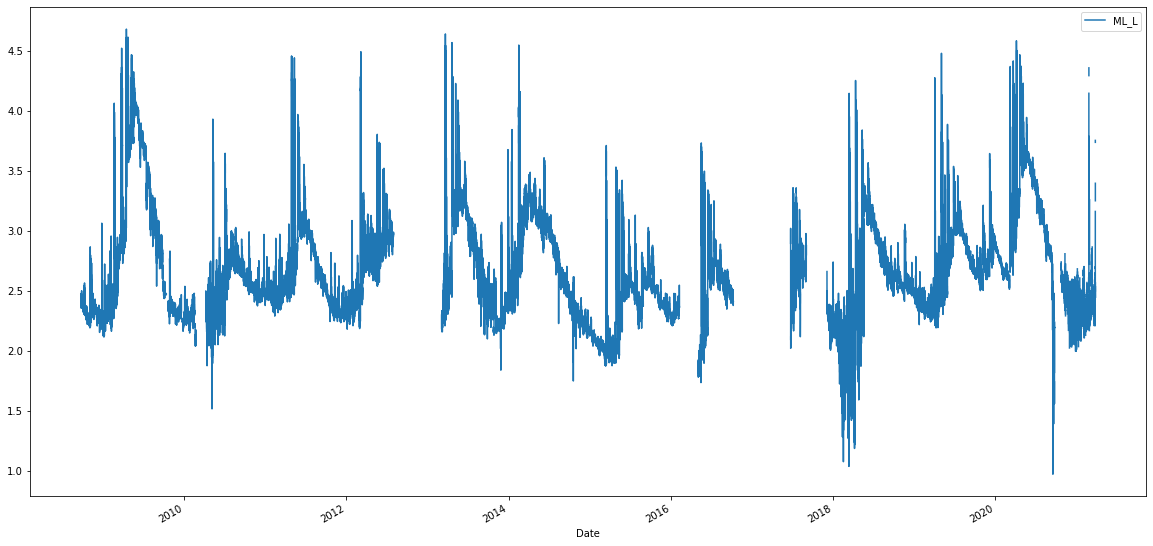

In [ ]:
df_oxy.plot(figsize=(20,10))

## Data Clean

### Oxygen

In [3]:
df_oxy = pd.read_csv('dwr_detection/All_Data/Oxygen_Hourly.csv', comment='#', usecols=[0,1], names=['Date','ML_L'])
df_oxy['Date'] = pd.to_datetime(df_oxy['Date']).dt.tz_localize(None)
df_oxy['ML_L'] = df_oxy.ML_L.astype('float')
df_oxy.index = df_oxy['Date']

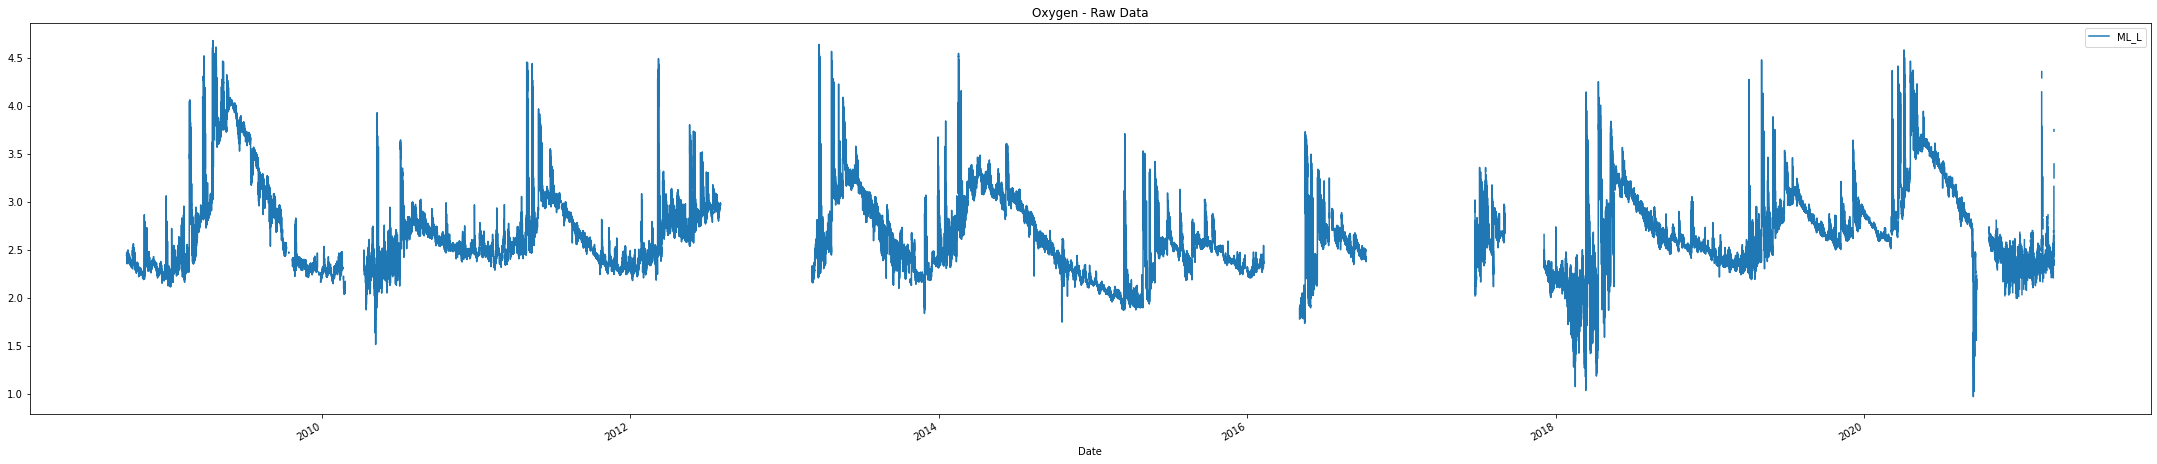

In [4]:
df_oxy.plot('Date','ML_L', figsize=(38,8), title='Oxygen - Raw Data')

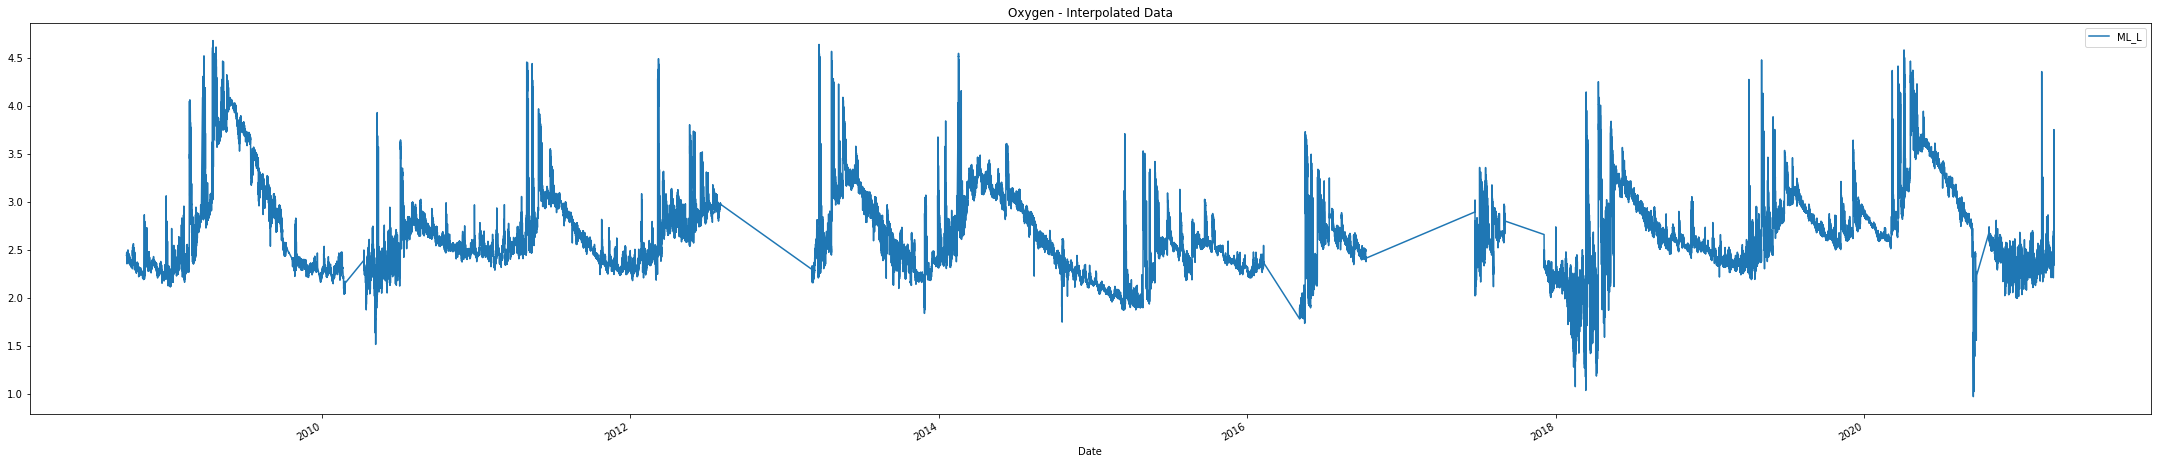

In [5]:
df_oxy.interpolate(method='slinear').plot('Date','ML_L',figsize=(38,8), title='Oxygen - Interpolated Data')

### Salinity

In [6]:
df_sal = pd.read_csv('dwr_detection/All_Data/Salinity_Hourly.csv', comment='#', usecols=[0,1], names=['Date','PSU'])

In [7]:
df_sal['Date'] = pd.to_datetime(df_sal['Date']).dt.tz_localize(None)
df_sal['PSU'] = df_sal.PSU.astype('float')
df_sal.index = df_sal['Date']

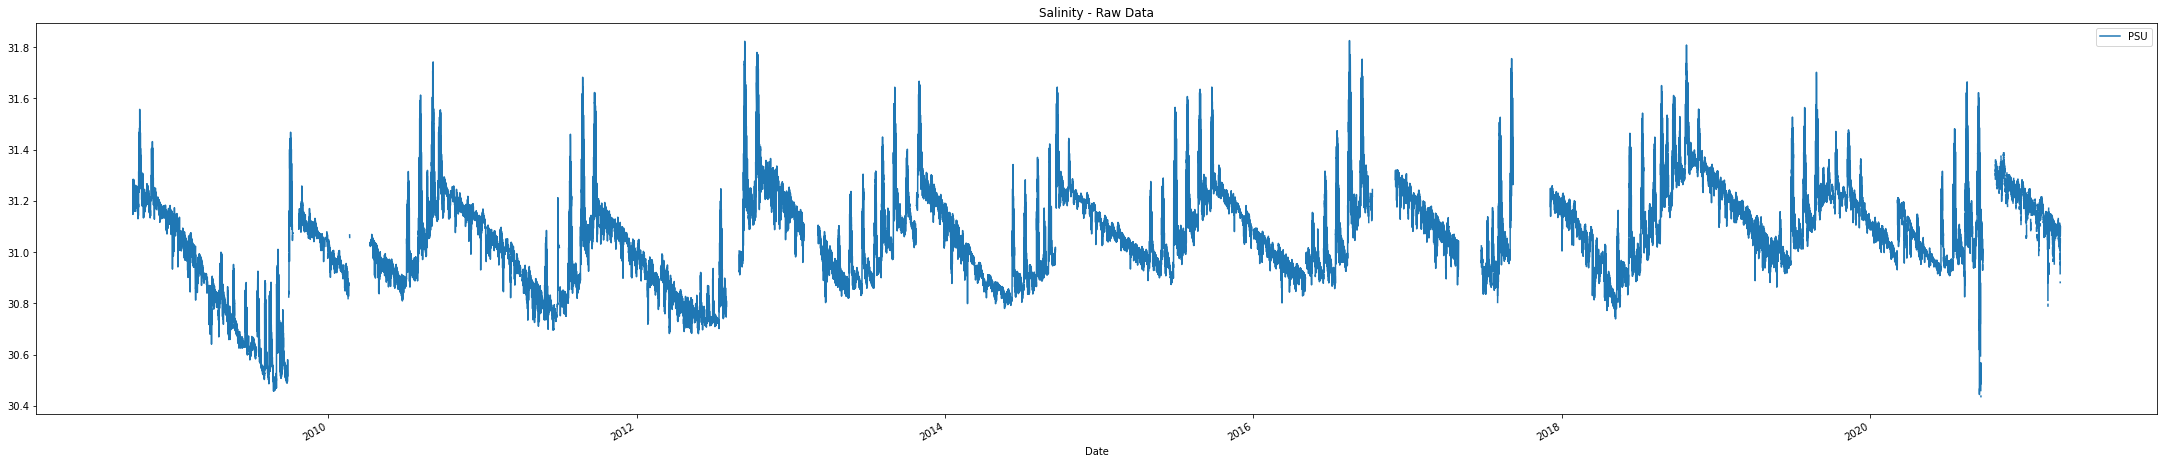

In [8]:
df_sal.plot('Date','PSU',figsize=(38, 8), title='Salinity - Raw Data')

In [9]:
df_sal_interp = df_sal.loc[:,['Date','PSU']].interpolate(method='time', order=3)

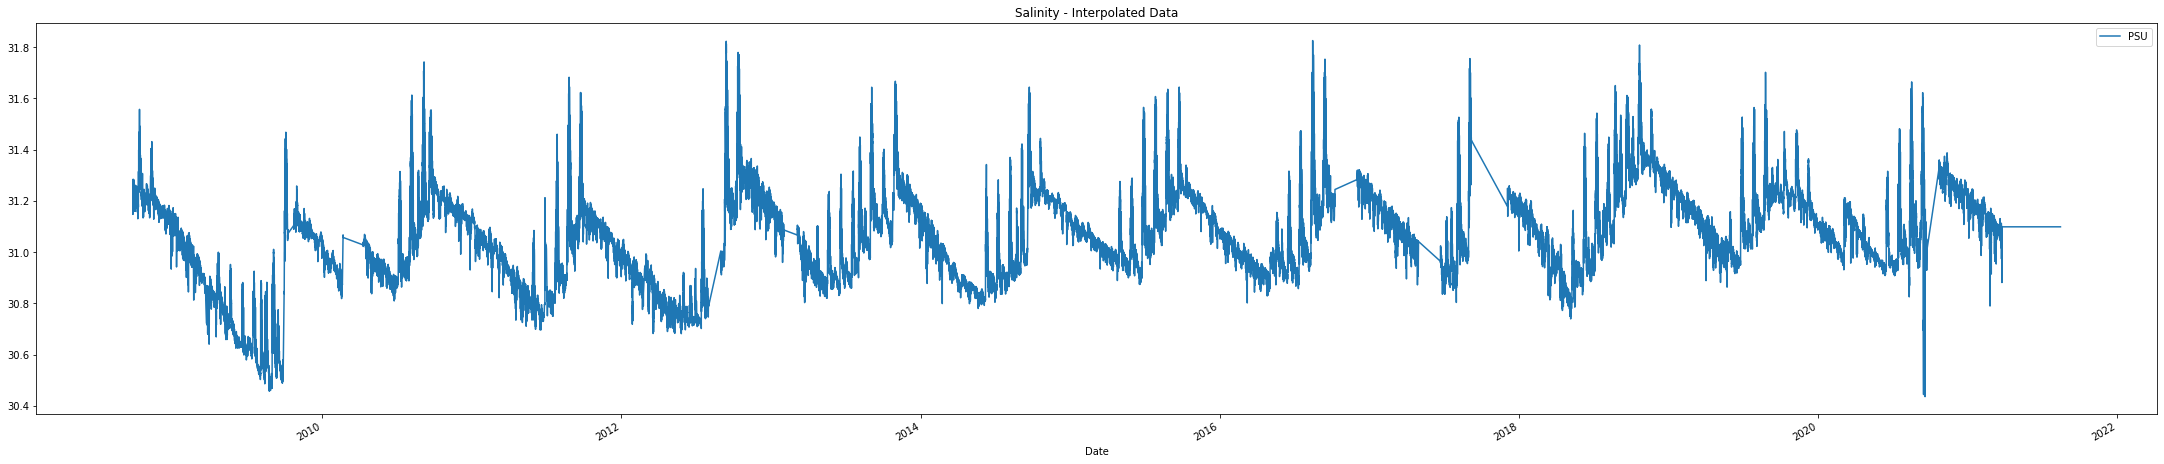

In [10]:
df_sal_interp.plot('Date','PSU',figsize=(38,8), title='Salinity - Interpolated Data')

### Temperature

In [11]:
df_temp = pd.read_csv('dwr_detection/All_Data/Alt_Temperature_Hourly.csv', comment='#', usecols=[0,1], names=['Date','Celsius'])
df_temp['Date'] = pd.to_datetime(df_temp['Date']).dt.tz_localize(None)
df_temp['Celsius'] = df_temp.Celsius.astype('float')
df_temp.index = df_temp['Date']

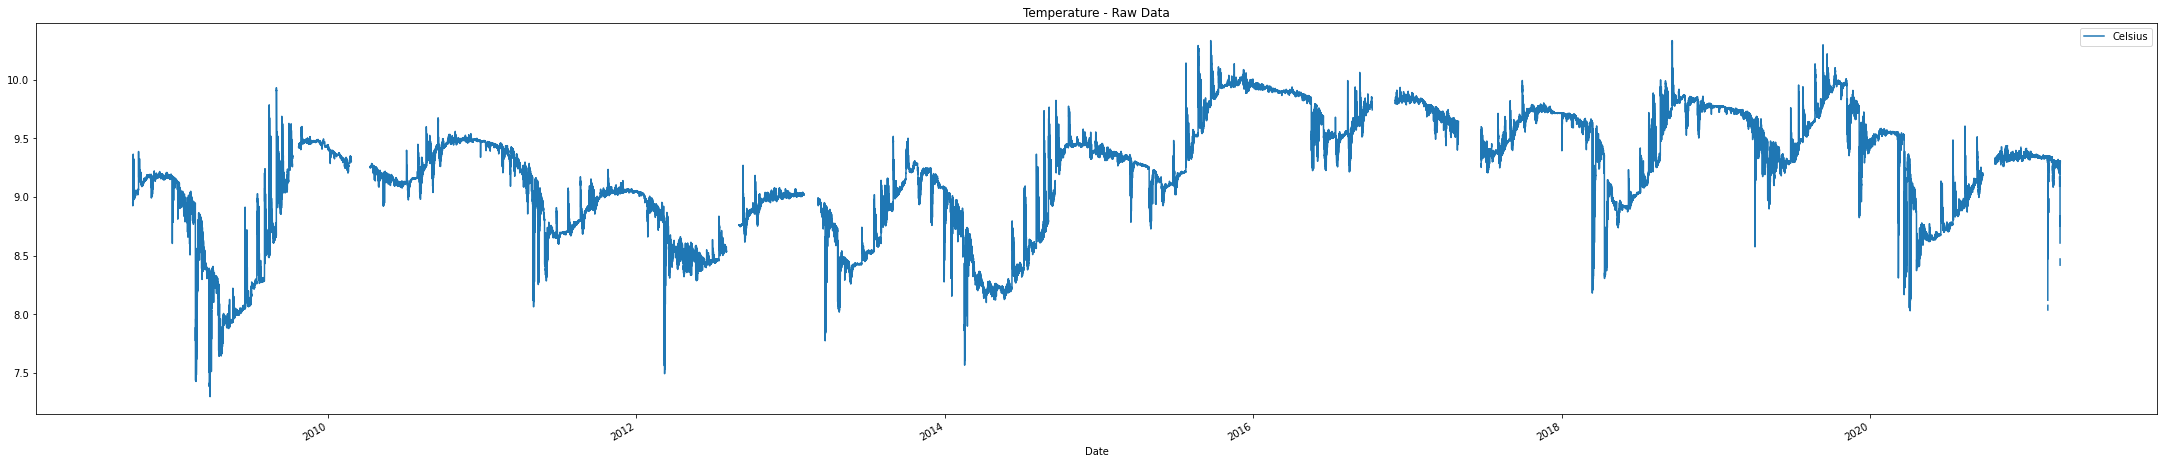

In [12]:
df_temp.plot('Date','Celsius',figsize=(38,8), title='Temperature - Raw Data')

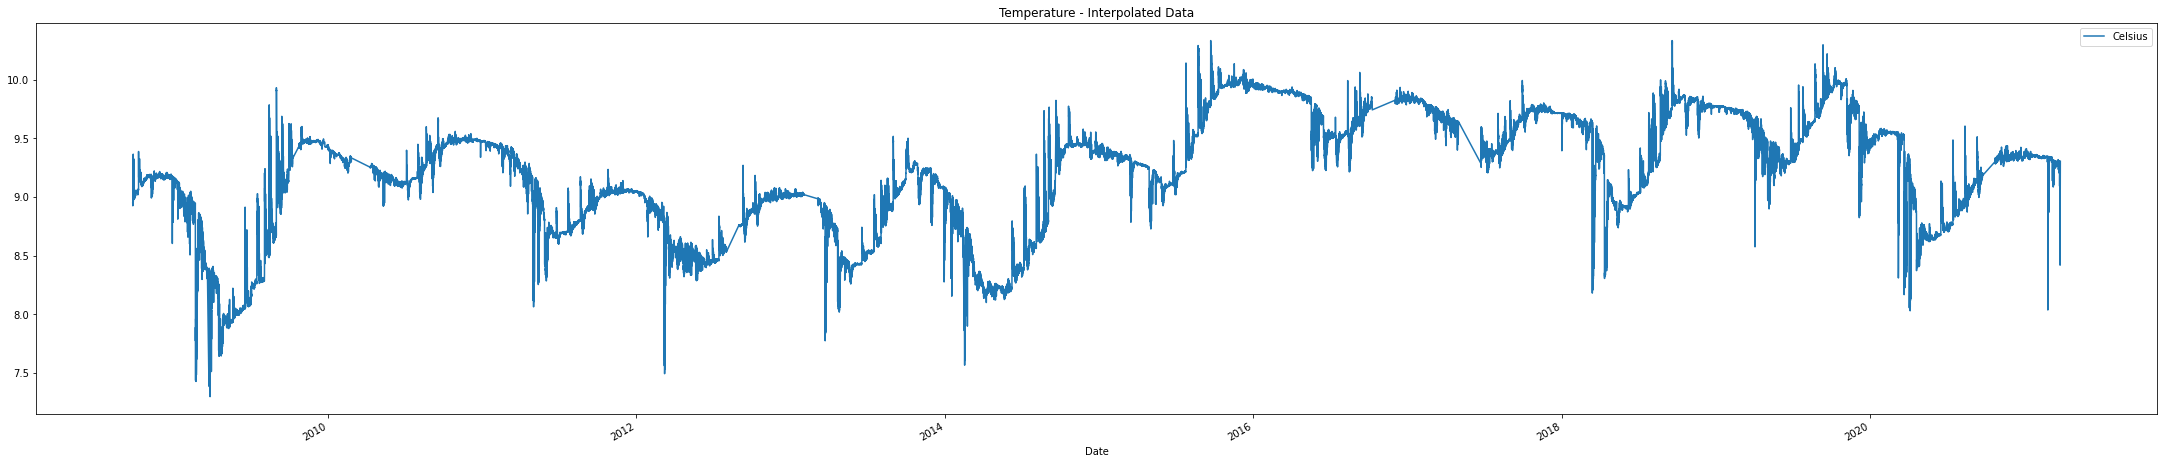

In [13]:
df_temp.interpolate(method='slinear').plot('Date','Celsius',figsize=(38,8), title='Temperature - Interpolated Data')

### Pressure

In [14]:
df_pressure = pd.read_csv('dwr_detection/All_Data/Pressure_Hourly.csv', comment='#', usecols=[0,1], names=['Date','Decibar'])
df_pressure['Date'] = pd.to_datetime(df_pressure['Date']).dt.tz_localize(None)
df_pressure['Decibar'] = df_pressure.Decibar.astype('float')
df_pressure.index = df_pressure['Date']

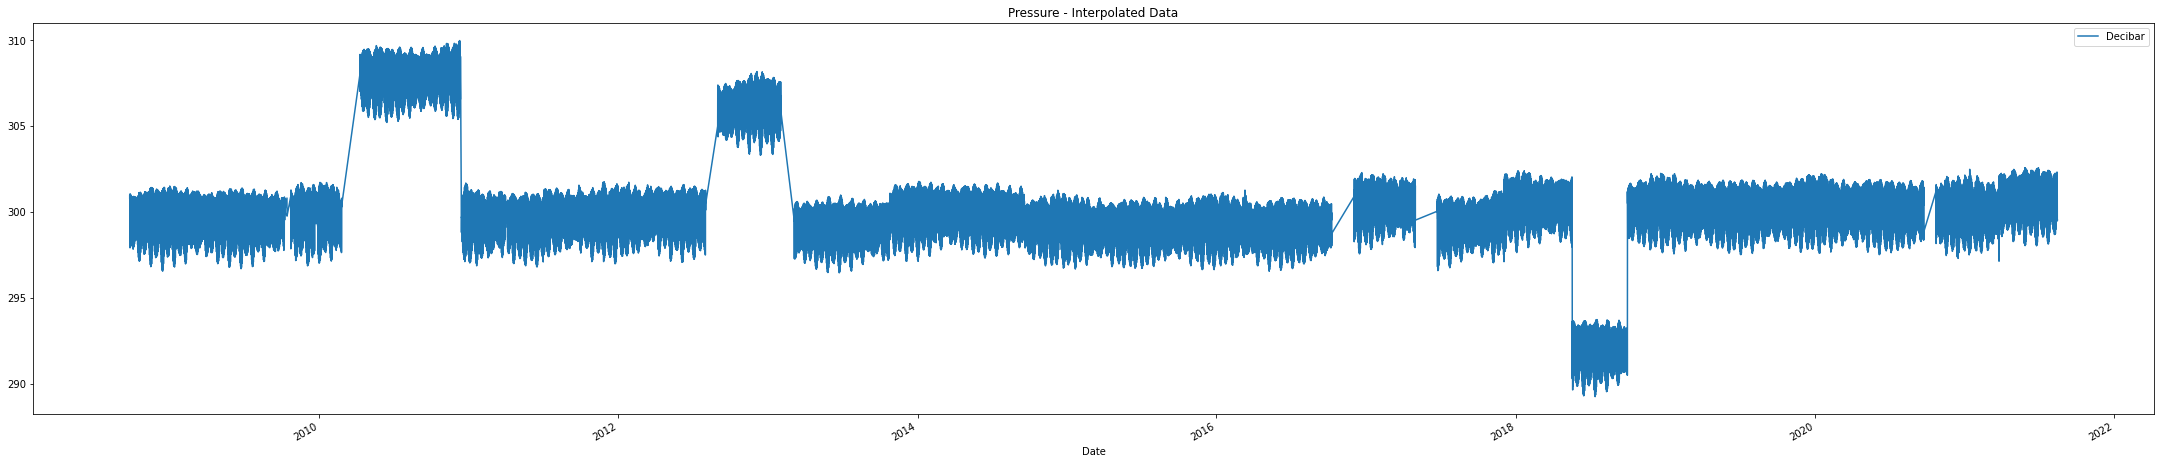

In [15]:
df_pressure.interpolate(method='time').plot('Date','Decibar',figsize=(38,8), title='Pressure - Interpolated Data')

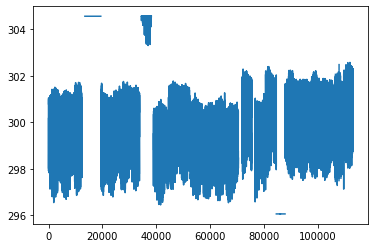

In [16]:
p_mean = df_pressure['Decibar'].mean()
p_std = df_pressure['Decibar'].std()

upper_limit = p_mean + 1.5 * p_std
lower_limit = p_mean - 1.5 * p_std

pd.Series(min(max(p, lower_limit), upper_limit) for p in df_pressure['Decibar']).plot()

### All Data

In [15]:
df_all = df_oxy.join([df_sal, df_temp, df_pressure])
df_all = df_all.drop(['Date_x','Date_y'], axis=1).iloc[1:-1]
df_all = df_all[~df_all.index.duplicated(keep='first')]


In [70]:
df_all.head()

ML_L        PSU   Celsius     Decibar
Date                                                          
2008-09-24 21:30:00  2.440997  31.192082  8.950633  300.789067
2008-09-24 22:30:00  2.443306  31.187740  8.947650  300.980050
2008-09-24 23:30:00  2.439601  31.186483  8.945462  300.929617
2008-09-25 00:30:00  2.450794  31.169812  8.936242  300.744333
2008-09-25 01:30:00  2.452126  31.162445  8.931967  300.444450

In [16]:
df_all.loc['2010-04-07':'2010-12-10', 'Decibar'] = df_all.loc['2010-04-07':'2010-12-10', 'Decibar'] - 8
df_all.loc['2016-12-01':'2017-05-02', 'Decibar'] = df_all.loc['2016-12-03':'2017-05-02', 'Decibar'] - 1
df_all.loc[df_all['Decibar'] < 296, 'Decibar'] = df_all.loc[df_all['Decibar'] < 296, 'Decibar'] + 8
df_all.loc[df_all['Decibar'] > 303, 'Decibar'] = df_all.loc[df_all['Decibar'] > 303, 'Decibar'] - 7

In [17]:
index = pd.date_range('2008-09-24 21:30:00', '2021-08-15 13:30:00', freq='H')

In [18]:
df_all = df_all.reindex(index)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb14d4ca550>,
      dtype=object)

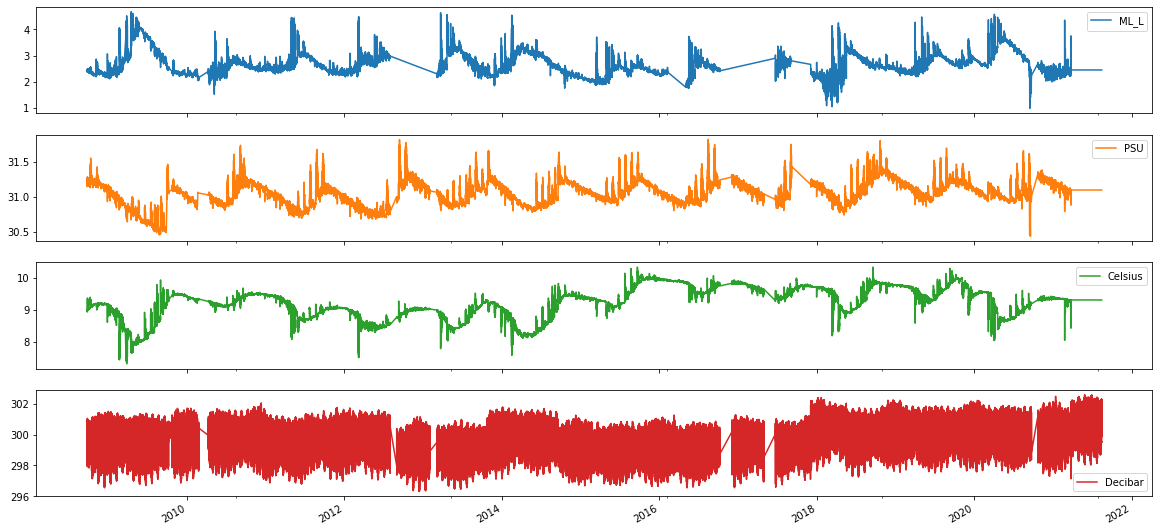

In [19]:
df_all = df_all.interpolate(method='time').dropna()
df_all.plot(subplots=True, figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb14e9b1690>,
      dtype=object)

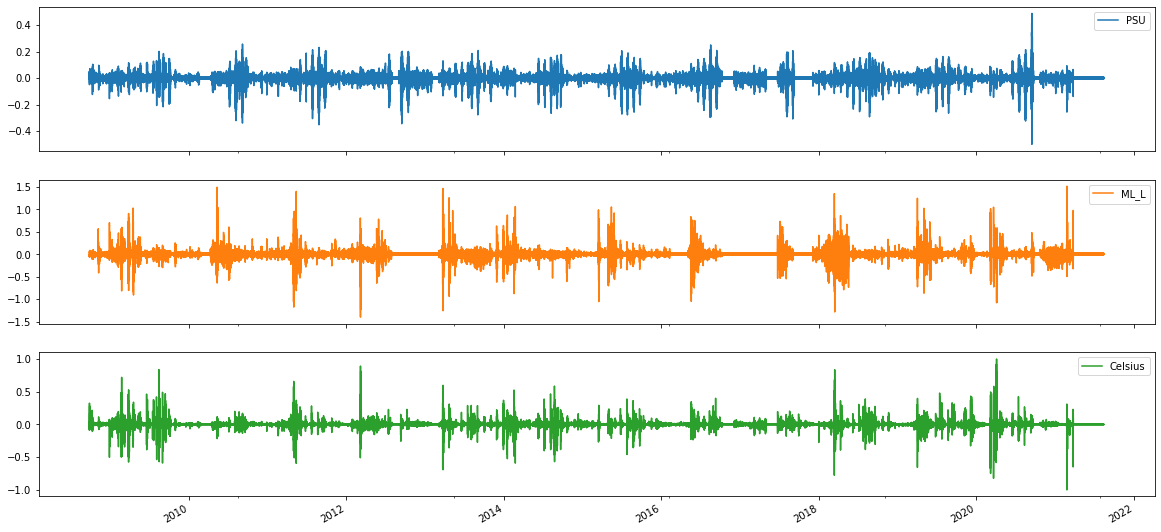

In [22]:
decomposition = sm.tsa.seasonal_decompose(df_all.loc[:,['PSU','ML_L','Celsius']])
decomposition.resid.plot(figsize=(20,10), subplots=True)

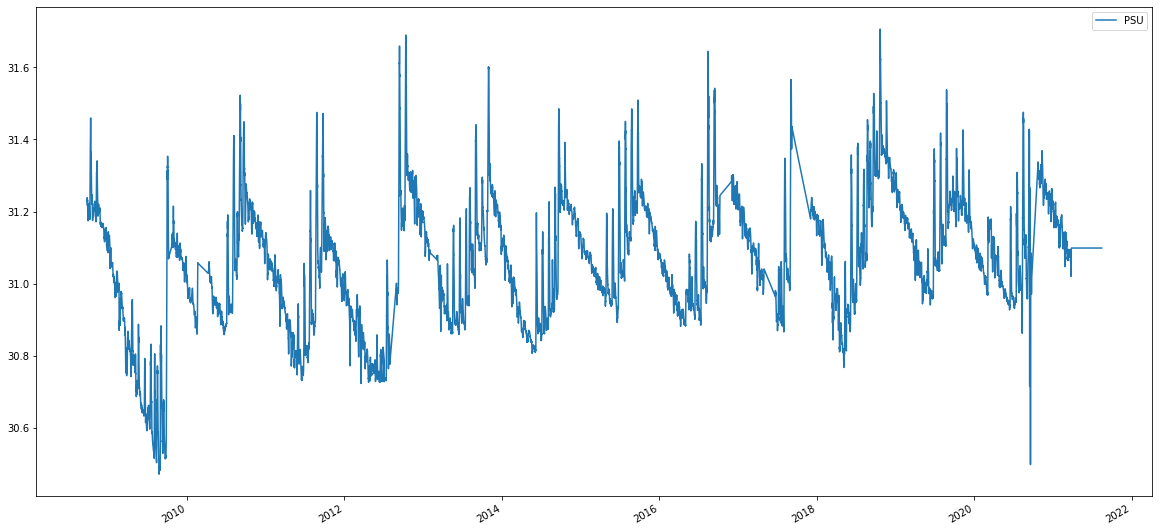

In [111]:
sm.tsa.seasonal_decompose(df_all.loc[:,['PSU']]).trend.plot(figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f504d89d910>,
      dtype=object)

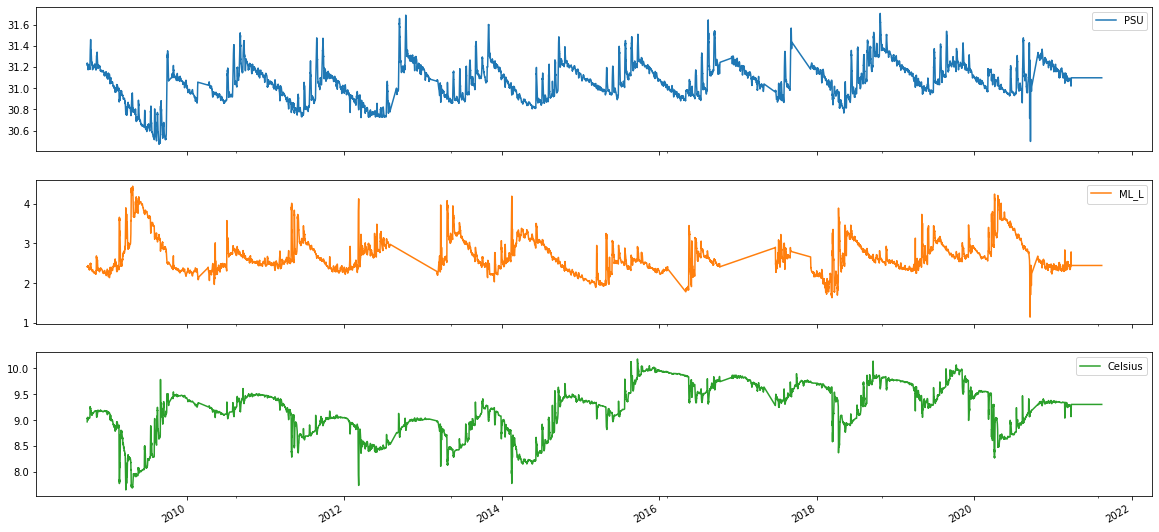

In [75]:
decomposition.trend.plot(figsize=(20,10), subplots=True)

In [23]:
df_resid = decomposition.resid.dropna()
df_resid = pd.concat([df_resid, df_all['Decibar']], axis=1).dropna()

In [20]:
hour_freq = 12
f'{hour_freq}H'

'12H'

In [24]:
df_resid = df_resid.resample(f'{hour_freq}H', origin='start').mean()
df_all = df_all.resample(f'{hour_freq}H', origin='start').mean()

In [25]:
df_resid = df_all.dropna()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb14b7acd90>,
      dtype=object)

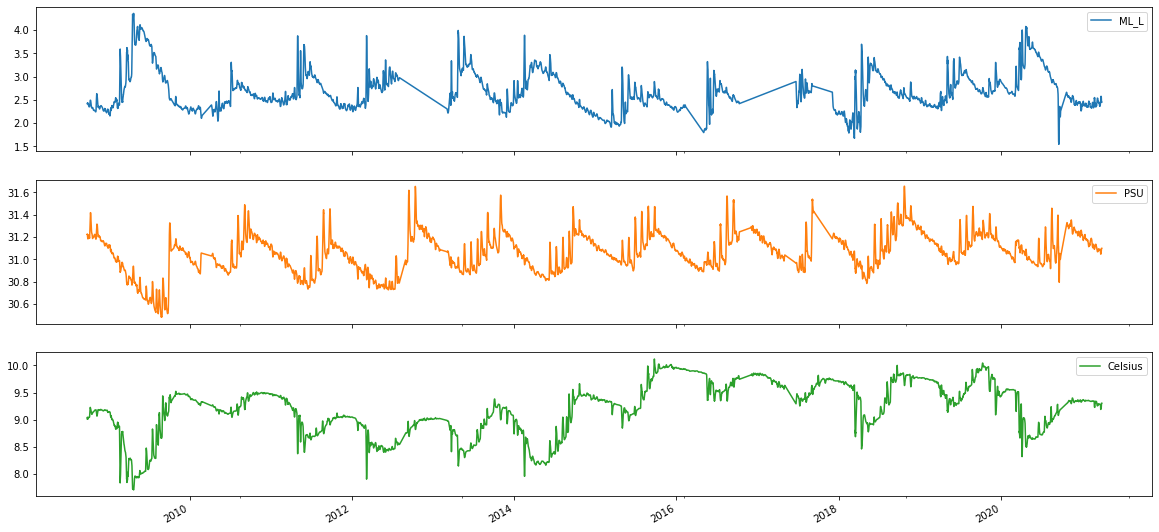

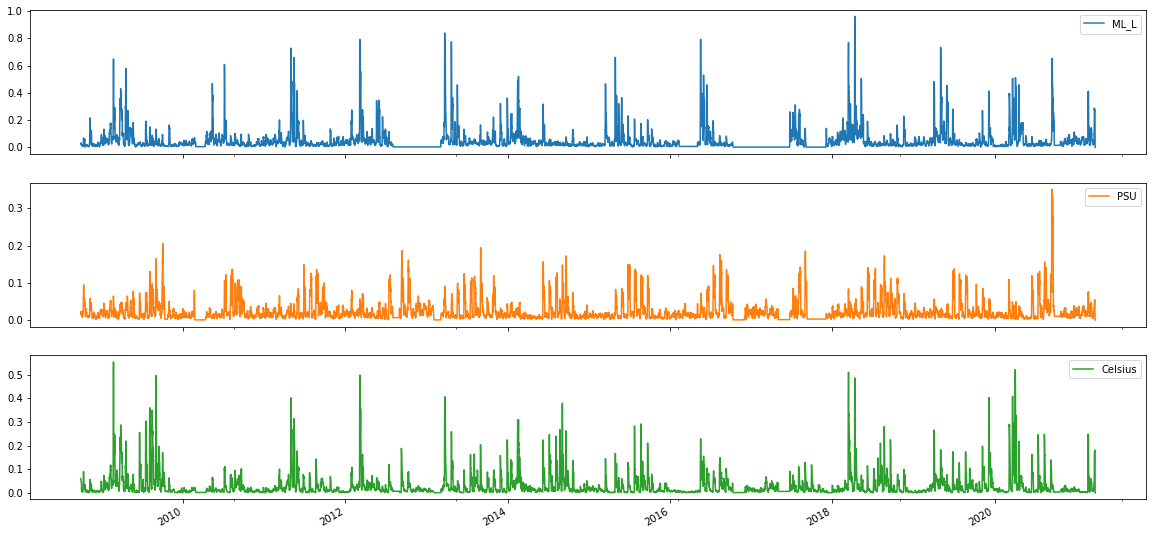

In [26]:
df_resid = df_resid[df_resid.index < '2021-03-30']

num_days = 3
window = int(24/hour_freq) * num_days
#df_resid_mean = pd.concat([df_resid.iloc[:,0:3].rolling(window).mean(), df_resid.Decibar], axis=1).dropna()
df_resid_mean = df_resid.iloc[:,0:3].rolling(window).mean().dropna()
df_resid_std = df_resid.iloc[:,0:3].rolling(window).std().dropna()

df_resid_mean.plot(subplots=True, figsize=(20,10))
df_resid_std.plot(subplots=True, figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f51b634e410>,
      dtype=object)

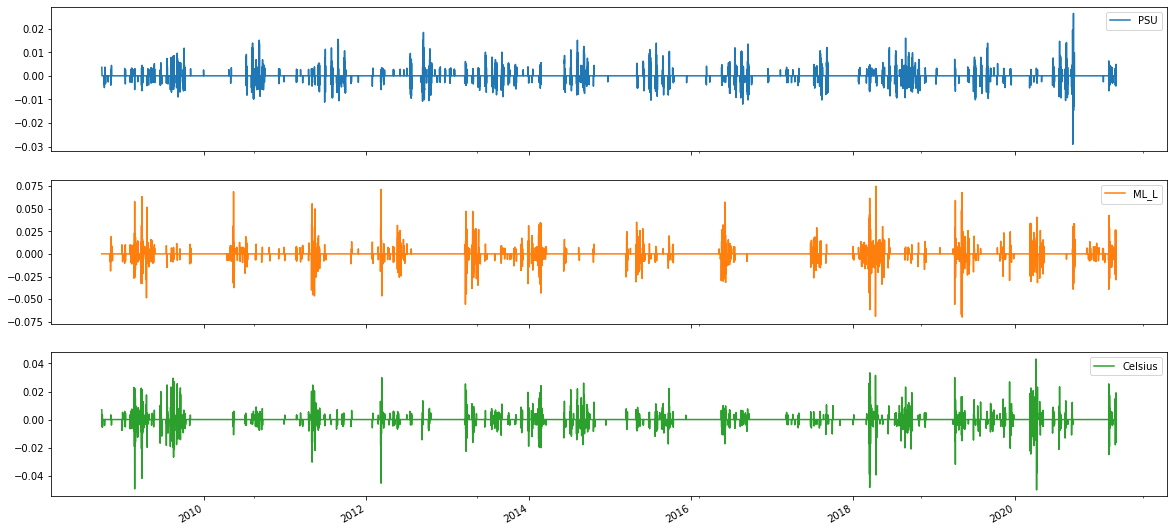

In [93]:
thresh = df_resid_std.mean() *0.2
df_resid_mean[df_resid_mean.abs() >thresh].fillna(0).plot(subplots=True, figsize=(20,10))

In [94]:
df_resid_mean = df_resid_mean[df_resid_mean.abs() >thresh].fillna(0)

In [27]:
df_all_mean = pd.concat([df_resid_mean, df_resid['Decibar']], axis=1).dropna()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb14b98bc10>,
      dtype=object)

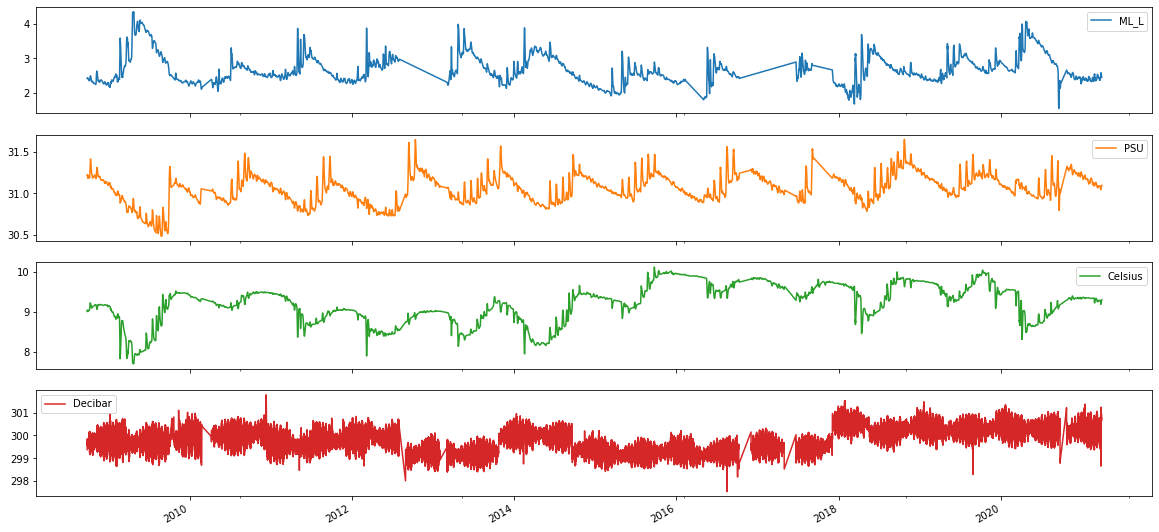

In [28]:
df_all_mean.plot(subplots=True, figsize=(20,10))

## Model Definition

In [29]:
# Define Model
class GRUCNN(nn.Module):
    # initialize with variables in_channels, and nonlinearity
    def __init__(self, in_channels, out_length, parameterization, nonlinearity="tanh"): 
        super(GRUCNN, self).__init__()
        self.in_channels = in_channels
        self.out_length = out_length
        self.activation =  nn.ReLU() if nonlinearity=="relu" else nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.dilation = parameterization.get('dilation', 1)
        self.kernal_size = parameterization.get('kernal size', 5)
        self.batch_size = parameterization.get('batchsize', 8)

        # local pattern analysis submodule:  extracts local attributes from seismic traces that best model high-frequency trends of EI trace
        self.cnn1 = nn.Sequential(nn.Conv1d(in_channels=self.in_channels,
                                           out_channels=12,
                                           kernel_size=self.kernal_size,
                                           padding='same',
                                           dilation=self.dilation),
                                  nn.GroupNorm(num_groups=self.in_channels,
                                               num_channels=12))

        self.cnn2 = nn.Sequential(nn.Conv1d(in_channels=self.in_channels,
                                           out_channels=12,
                                           kernel_size=self.kernal_size,
                                           padding='same',
                                           dilation=self.dilation * 3),
                                  nn.GroupNorm(num_groups=self.in_channels,
                                               num_channels=12))

        self.cnn3 = nn.Sequential(nn.Conv1d(in_channels=self.in_channels,
                                           out_channels=12,
                                           kernel_size=self.kernal_size,
                                           padding='same',
                                           dilation=self.dilation * 6),
                                  nn.GroupNorm(num_groups=self.in_channels,
                                               num_channels=12))

        self.cnn = nn.Sequential(self.activation,
                                 self.dropout,
                                 nn.Conv1d(in_channels=36,
                                           out_channels=24,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=self.in_channels,
                                              num_channels=24),
                                 self.activation,
                                 self.dropout,

                                 nn.Conv1d(in_channels=24,
                                           out_channels=24,
                                           kernel_size=3,
                                           padding=1),
                                 nn.GroupNorm(num_groups=self.in_channels,
                                              num_channels=24),
                                 self.activation,
                                 self.dropout,

                                 nn.Conv1d(in_channels=24,
                                           out_channels=24,
                                           kernel_size=1),
                                 nn.GroupNorm(num_groups=self.in_channels,
                                              num_channels=24),
                                 self.activation,
                                 self.dropout
                                 )
        
        # sequence modeling submodule: models temporal dynamics of seismic traces and produces features that best represent the low-frequency content of EI
        self.gru = nn.GRU(input_size=self.in_channels,
                          hidden_size=12,
                          num_layers=self.in_channels,
                          batch_first=True,
                          bidirectional=True)
        
        self.out = nn.Linear(in_features= 24 * out_length * 5, out_features=out_length * self.in_channels)

        
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                nn.init.xavier_uniform_(m.weight.data)
                m.bias.data.zero_()
            elif isinstance(m, nn.GroupNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    # specify how data will pass through the network 
    def forward(self, x):
        cnn_out1 = self.cnn1(x)
        #print("cnn 1 output shape:", cnn_out1.shape)
        cnn_out2 = self.cnn2(x)
        #print("cnn 2 output shape:", cnn_out2.shape)
        cnn_out3 = self.cnn3(x)
        #print("cnn 3 output shape:", cnn_out3.shape)

        cnn_out = self.cnn(torch.cat((cnn_out1,cnn_out2,cnn_out3),dim=1))
        #print("cnn output shape:", cnn_out.shape)

        #[batch size, features, length] to [batch_size, length, features]
        tmp_x = x.transpose(-1, -2)
        #print("temp x shape:", tmp_x.shape)

        rnn_out, _ = self.gru(tmp_x)
        #print("rnn output shape:", rnn_out.shape)
        #[batch size, length, hidden] to [batch size, hidden, length]
        rnn_out = rnn_out.transpose(-1, -2)
        #print("rnn output tranposed shape:", rnn_out.shape)

        x = rnn_out + cnn_out
        #print("additive output shape:", x.shape)

        #[batch size, hidden, length] to [batch size, hidden]
        tmp_x = torch.reshape(x, (self.batch_size, -1))
        #print("transposed shape:", tmp_x.shape)
        
        #expects [batch size, hidden]
        x = self.out(tmp_x)
        #print("linear output shape:", x.shape)

        x = torch.reshape(x, (self.batch_size, out_length, self.in_channels))
        #x = x.transpose(-1,-2)

        return x
#how to figure out tensor shapes https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

In [30]:
class SalDataset(data.Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [31]:
class Normalization:
    def __init__(self, mean_val=None,std_val=None):
        self.mean_val = mean_val
        self.std_val = std_val

    def normalize(self, x):
        return np.divide((x-self.mean_val),self.std_val)

    def unnormalize(self, x):
        return x*self.std_val + self.mean_val

def data_norm(x):
  x_mean = np.mean(x, axis=0)
  x_std = np.std(x, axis=0)
  #print("x_mean", x_mean.shape)
  #print("x_std", x_std.shape)
  #x_mean = torch.tensor(np.mean(x)).float()
  #x_std = torch.tensor(np.std(x)).float()

  x_normalization = Normalization(mean_val=x_mean, std_val=x_std)

  #x = torch.tensor(x).float()

  x_normalized = x_normalization.normalize(x)

  return x_normalized

## Split Train/Test Sets

In [32]:
df_all_mean['Time'] = df_all_mean.index.values

signal_train = df_all_mean[df_all_mean["Time"].dt.year <= 2015].loc[:,["PSU", "ML_L", "Celsius"]]
signal_test = df_all_mean[df_all_mean["Time"].dt.year >= 2015].loc[:,["PSU", "ML_L", "Celsius"]]


out_length = len(df_all_mean.loc['2010-01-01':'2011-01-01'])
seq_length = out_length * 5


def create_inout_sequences(input_data, seq_length):
    X, y = list(), list()
    L = len(input_data)
    for i in range(L-seq_length):
        seq = input_data[i:i+seq_length]
        label = input_data[i+seq_length:i+seq_length+out_length,0:3]
        if (len(label) == out_length) & (len(seq) == seq_length): #if the length isn't correct - don't append
          X.append(seq)
          y.append(label)
    return np.array(X), np.array(y)


train_X, train_y = create_inout_sequences(data_norm(signal_train.to_numpy()), seq_length)
#val_X, val_y = create_inout_sequences(data_norm(signal_val.to_numpy()), seq_length)
test_X, test_y = create_inout_sequences(data_norm(signal_test.to_numpy()),seq_length)

num_features = 3

# [sample size, length, num_features] to [sample size, num_features, length]
train_X = np.moveaxis(train_X, 1, -1)
#val_X = np.moveaxis(val_X, 1, -1)
test_X = np.moveaxis(test_X, 1, -1)
#train_dataloader = data.DataLoader(train_inout_seq, batch_size=8)
#test_dataloader = data.DataLoader(test_inout_seq, batch_size=8)

In [ ]:
test_X.shape

(169, 3, 3660)

## Init Net

In [33]:
def init_net(parameterization):
  input_channel = num_features

  gru_cnn = GRUCNN(input_channel, out_length, parameterization)


  return gru_cnn

## Training

In [34]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter % 5 == 0:
              print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [37]:
def net_train(net, train_loader, val_loader, parameters, dtype, device):
  num_epochs = 200

  net.to(device)

  loss_function = torch.nn.MSELoss()
  optimizer = optim.Adam(net.parameters(), 
                         lr=parameters.get('lr', .005), 
                         weight_decay=parameters.get('weight decay', 1e-04))

  train_losses = []
  val_losses = []
  early_stopping = EarlyStopping(patience=5)

  for epoch in range(num_epochs+1):
    net.train()
    running_loss = []
    for inputs, labels in train_loader:
      
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      #print(inputs.shape)
      outputs = net(inputs.float())
      #print("output shape:", outputs.shape)
      #print("label shape:", labels.shape)
      loss = loss_function(outputs, labels.float())
      loss.backward()
      
      running_loss.append(loss)

      optimizer.step()

    epoch_train_loss = torch.mean(torch.stack(running_loss))
    train_losses.append(epoch_train_loss)
    
    net.eval()

    with torch.no_grad():
      running_loss = []
      real = []
      predictions = []
      for x_val, y_val in val_loader:
        real.append(y_val)
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        yhat = net(x_val.float())
        predictions.append(yhat)
        val_loss = loss_function(yhat, y_val.float())
        running_loss.append(val_loss)
      epoch_validation_loss = torch.mean(torch.stack(running_loss))
      val_losses.append(epoch_validation_loss)

    print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, epoch_train_loss, epoch_validation_loss))
    
    
    early_stopping(epoch_validation_loss)
    if early_stopping.early_stop:
      break

  import matplotlib.pyplot as plt
  
  plt.figure(figsize=(10,10))
  plt.plot(train_losses, label = "train")
  plt.plot(val_losses, label = "validation")
  plt.ylabel('MSE loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()
  return net

  

## Bayesian Optimization

In [ ]:
!pip install ax-platform

     |████████████████████████████████| 866 kB 5.0 MB/s 
     |████████████████████████████████| 486 kB 49.3 MB/s 
     |████████████████████████████████| 503 kB 63.7 MB/s 


In [ ]:
from ax.service.managed_loop import optimize

def train_evaluate(parameterization):
    print(parameterization)
    # constructing a new training data loader allows us to tune the batch size
    train = SalDataset(train_X, train_y)
    train_loader = torch.utils.data.DataLoader(train,
                                              batch_size= parameterization.get('batchsize', 8),
                                              drop_last=True,
                                              shuffle=False)
    
    #train_loader = torch.utils.data.DataLoader(train,batch_size=8,drop_last=True,shuffle=False)
    val = SalDataset(val_X, val_y)
    val_loader = torch.utils.data.DataLoader(val,
                                           batch_size=parameterization.get('batchsize', 8),
                                           drop_last=True,
                                           shuffle=False)
    test = SalDataset(test_X, test_y)
    test_loader = torch.utils.data.DataLoader(test,
                                            batch_size=parameterization.get('batchsize', 8),
                                            drop_last=True,
                                            shuffle=False)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, val_loader=val_loader,
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        test_loader=test_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {'name': 'dilation', 'type': 'range', 'bounds': [1, 4]},
        {'name': 'kernal size', 'type': 'range', 'bounds': [3, 15]},
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        #{"name": "batchsize", "type": "choice", "values": [8, 16, 32, 64]},
        #{"name": "weight decay", "type": "range", "bounds": [0.0, 1e-2]},
        #{"name": "stepsize", "type": "range", "bounds": [20, 40]},        
    ],
    evaluation_function=train_evaluate,
    minimize=True,
)

[INFO 11-18 05:09:58] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter dilation. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 05:09:58] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter kernal size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 05:09:58] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 05:09:58] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 11-18 05:09:58] ax.modelbridge.dispatch_utils: Using 

{'dilation': 2, 'kernal size': 10, 'lr': 3.528635759704356e-05}
Epoch: 0, train loss: 0.42123, val loss: 18.96729
Epoch: 1, train loss: 0.84216, val loss: 49.62952
Epoch: 2, train loss: 5.06225, val loss: 29.78147
Epoch: 3, train loss: 14.01038, val loss: 45.88580
Epoch: 4, train loss: 19.36773, val loss: 22.59722
Epoch: 5, train loss: 7.40519, val loss: 15.55695
Epoch: 6, train loss: 3.83621, val loss: 9.09852
Epoch: 7, train loss: 1.78030, val loss: 4.67329
Epoch: 8, train loss: 1.30480, val loss: 8.16116
Epoch: 9, train loss: 1.42377, val loss: 1.13013
Epoch: 10, train loss: 0.74291, val loss: 6.05888
Epoch: 11, train loss: 1.43519, val loss: 7.38368
Epoch: 12, train loss: 1.33030, val loss: 1.89240
Epoch: 13, train loss: 0.77258, val loss: 11.18551
Epoch: 14, train loss: 1.28260, val loss: 13.19649
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 05:22:25] ax.service.managed_loop: Running optimization trial 2...


{'dilation': 3, 'kernal size': 5, 'lr': 0.011770085293229603}
Epoch: 0, train loss: 115.87054, val loss: 115.94409
Epoch: 1, train loss: 9.14901, val loss: 4.11452
Epoch: 2, train loss: 1.43489, val loss: 1.72848
Epoch: 3, train loss: 0.61697, val loss: 0.68254
Epoch: 4, train loss: 0.38986, val loss: 0.68898
Epoch: 5, train loss: 0.28835, val loss: 1.03832
Epoch: 6, train loss: 0.25996, val loss: 1.02654
Epoch: 7, train loss: 0.22267, val loss: 0.95166
Epoch: 8, train loss: 0.19418, val loss: 0.67173
Epoch: 9, train loss: 0.18434, val loss: 0.77567
Epoch: 10, train loss: 0.16617, val loss: 0.80684
Epoch: 11, train loss: 0.16792, val loss: 0.86966
Epoch: 12, train loss: 0.15981, val loss: 0.80211
Epoch: 13, train loss: 0.16389, val loss: 0.83489
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 05:33:49] ax.service.managed_loop: Running optimization trial 3...
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning:

Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)



{'dilation': 3, 'kernal size': 8, 'lr': 0.00015266371654738616}
Epoch: 0, train loss: 0.67847, val loss: 3.64260
Epoch: 1, train loss: 0.55373, val loss: 3.74973
Epoch: 2, train loss: 0.54306, val loss: 7.54726
Epoch: 3, train loss: 1.04517, val loss: 6.96813
Epoch: 4, train loss: 1.25374, val loss: 26.83547
Epoch: 5, train loss: 1.29689, val loss: 117.34837
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 05:38:44] ax.service.managed_loop: Running optimization trial 4...


{'dilation': 1, 'kernal size': 9, 'lr': 5.669993028522356e-06}
Epoch: 0, train loss: 0.68065, val loss: 0.73466
Epoch: 1, train loss: 0.43893, val loss: 0.62233
Epoch: 2, train loss: 0.37954, val loss: 0.85890
Epoch: 3, train loss: 0.33094, val loss: 0.80558
Epoch: 4, train loss: 0.27905, val loss: 0.62137
Epoch: 5, train loss: 0.24244, val loss: 0.54223
Epoch: 6, train loss: 0.21740, val loss: 0.52908
Epoch: 7, train loss: 0.19686, val loss: 0.55371
Epoch: 8, train loss: 0.17689, val loss: 0.57635
Epoch: 9, train loss: 0.15814, val loss: 0.56537
Epoch: 10, train loss: 0.14193, val loss: 0.54106
Epoch: 11, train loss: 0.12909, val loss: 0.52945
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 05:48:34] ax.service.managed_loop: Running optimization trial 5...


{'dilation': 3, 'kernal size': 13, 'lr': 0.0046560059318983184}
Epoch: 0, train loss: 69.38580, val loss: 574.73541
Epoch: 1, train loss: 126.93899, val loss: 7.59455
Epoch: 2, train loss: 3.00775, val loss: 9.46668
Epoch: 3, train loss: 1.00031, val loss: 3.94580
Epoch: 4, train loss: 0.67919, val loss: 1.90015
Epoch: 5, train loss: 0.47580, val loss: 2.53980
Epoch: 6, train loss: 0.40995, val loss: 3.05915
Epoch: 7, train loss: 0.34856, val loss: 3.80514
Epoch: 8, train loss: 0.32952, val loss: 3.49592
Epoch: 9, train loss: 0.29399, val loss: 1.48360
Epoch: 10, train loss: 0.27114, val loss: 2.38503
Epoch: 11, train loss: 0.25709, val loss: 3.38956
Epoch: 12, train loss: 0.22631, val loss: 1.61475
Epoch: 13, train loss: 0.23474, val loss: 2.23983
Epoch: 14, train loss: 0.21428, val loss: 1.44170
Epoch: 15, train loss: 0.20085, val loss: 0.88849
Epoch: 16, train loss: 0.18117, val loss: 0.99732
Epoch: 17, train loss: 0.17775, val loss: 0.87884
Epoch: 18, train loss: 0.16706, val loss:

[INFO 11-18 06:16:04] ax.service.managed_loop: Running optimization trial 6...


{'dilation': 3, 'kernal size': 12, 'lr': 8.689291296878151e-05}
Epoch: 0, train loss: 0.45114, val loss: 11.60423
Epoch: 1, train loss: 0.74166, val loss: 67.90639
Epoch: 2, train loss: 2.68283, val loss: 506.65332
Epoch: 3, train loss: 11.66187, val loss: 1481.92297
Epoch: 4, train loss: 65.72923, val loss: 1157.66528
Epoch: 5, train loss: 106.53344, val loss: 121.91427
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 06:21:00] ax.service.managed_loop: Running optimization trial 7...


{'dilation': 3, 'kernal size': 12, 'lr': 0.08586902659955643}
Epoch: 0, train loss: 8244.87500, val loss: 1029.25378
Epoch: 1, train loss: 40.21432, val loss: 318.88422
Epoch: 2, train loss: 11.00859, val loss: 30.36657
Epoch: 3, train loss: 5.55120, val loss: 268.14966
Epoch: 4, train loss: 4.47006, val loss: 826.10272
Epoch: 5, train loss: 3.80020, val loss: 147.77629
Epoch: 6, train loss: 2.64033, val loss: 12.53138
Epoch: 7, train loss: 2.15455, val loss: 22.65027
Epoch: 8, train loss: 1.43847, val loss: 27.11839
Epoch: 9, train loss: 1.58031, val loss: 18.53937
Epoch: 10, train loss: 0.77654, val loss: 16.35238
Epoch: 11, train loss: 0.85411, val loss: 7.62411
Epoch: 12, train loss: 0.57364, val loss: 2.16950
Epoch: 13, train loss: 0.31162, val loss: 1.19287
Epoch: 14, train loss: 0.27435, val loss: 0.74979
Epoch: 15, train loss: 0.23730, val loss: 0.72415
Epoch: 16, train loss: 0.20974, val loss: 0.66534
Epoch: 17, train loss: 0.18324, val loss: 1.10463
Epoch: 18, train loss: 0.1

[INFO 11-18 06:43:16] ax.service.managed_loop: Running optimization trial 8...


{'dilation': 1, 'kernal size': 8, 'lr': 0.00023710164570660755}
Epoch: 0, train loss: 0.61871, val loss: 0.57081
Epoch: 1, train loss: 0.22834, val loss: 0.74360
Epoch: 2, train loss: 0.22337, val loss: 1.14621
Epoch: 3, train loss: 0.19227, val loss: 0.79544
Epoch: 4, train loss: 0.16240, val loss: 0.91974
Epoch: 5, train loss: 0.14050, val loss: 0.72754
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 06:48:18] ax.service.managed_loop: Running optimization trial 9...


{'dilation': 2, 'kernal size': 10, 'lr': 0.019163870759313112}
Epoch: 0, train loss: 880.06342, val loss: 1522.39294
Epoch: 1, train loss: 301.75818, val loss: 63.21004
Epoch: 2, train loss: 3.21249, val loss: 18.84898
Epoch: 3, train loss: 3.06862, val loss: 7.26382
Epoch: 4, train loss: 1.44451, val loss: 4.29151
Epoch: 5, train loss: 1.41437, val loss: 8.55050
Epoch: 6, train loss: 0.92304, val loss: 5.76509
Epoch: 7, train loss: 0.62289, val loss: 1.49428
Epoch: 8, train loss: 0.51256, val loss: 1.67507
Epoch: 9, train loss: 0.46463, val loss: 1.11673
Epoch: 10, train loss: 0.36725, val loss: 1.19250
Epoch: 11, train loss: 0.31647, val loss: 1.32401
Epoch: 12, train loss: 0.25231, val loss: 0.86010
Epoch: 13, train loss: 0.20877, val loss: 0.91403
Epoch: 14, train loss: 0.18687, val loss: 1.22693
Epoch: 15, train loss: 0.17972, val loss: 1.45258
Epoch: 16, train loss: 0.19097, val loss: 3.41646
Epoch: 17, train loss: 0.16957, val loss: 2.24070
INFO: Early stopping counter 5 of 5
IN

[INFO 11-18 07:03:16] ax.service.managed_loop: Running optimization trial 10...


{'dilation': 1, 'kernal size': 4, 'lr': 2.5101633500809552e-05}
Epoch: 0, train loss: 0.62163, val loss: 13.49749
Epoch: 1, train loss: 1.15293, val loss: 3.31680
Epoch: 2, train loss: 1.76993, val loss: 1.23229
Epoch: 3, train loss: 1.62292, val loss: 2.96858
Epoch: 4, train loss: 1.09713, val loss: 3.01459
Epoch: 5, train loss: 0.54971, val loss: 0.66425
Epoch: 6, train loss: 0.45887, val loss: 1.49860
Epoch: 7, train loss: 0.20040, val loss: 1.02917
Epoch: 8, train loss: 0.19431, val loss: 1.40480
Epoch: 9, train loss: 0.15958, val loss: 0.89202
Epoch: 10, train loss: 0.13190, val loss: 0.87476
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 07:12:30] ax.service.managed_loop: Running optimization trial 11...


{'dilation': 4, 'kernal size': 11, 'lr': 0.02636589970402258}
Epoch: 0, train loss: 936.69830, val loss: 135.29720
Epoch: 1, train loss: 13.57840, val loss: 85.83162
Epoch: 2, train loss: 2.41220, val loss: 49.25290
Epoch: 3, train loss: 2.57049, val loss: 8.28085
Epoch: 4, train loss: 0.76964, val loss: 7.67451
Epoch: 5, train loss: 0.62627, val loss: 7.01831
Epoch: 6, train loss: 0.45434, val loss: 4.40310
Epoch: 7, train loss: 0.42594, val loss: 12.84859
Epoch: 8, train loss: 0.44962, val loss: 14.96181
Epoch: 9, train loss: 0.52309, val loss: 7.67752
Epoch: 10, train loss: 0.33747, val loss: 2.73464
Epoch: 11, train loss: 0.29737, val loss: 1.94136
Epoch: 12, train loss: 0.29330, val loss: 2.06590
Epoch: 13, train loss: 0.27738, val loss: 1.80174
Epoch: 14, train loss: 0.26137, val loss: 1.74562
Epoch: 15, train loss: 0.24282, val loss: 1.21083
Epoch: 16, train loss: 0.22281, val loss: 1.28237
Epoch: 17, train loss: 0.21505, val loss: 0.78984
Epoch: 18, train loss: 0.19882, val los

[INFO 11-18 07:38:20] ax.service.managed_loop: Running optimization trial 12...


{'dilation': 1, 'kernal size': 14, 'lr': 4.0810945639215476e-05}
Epoch: 0, train loss: 0.38894, val loss: 8.69392
Epoch: 1, train loss: 0.57727, val loss: 18.58672
Epoch: 2, train loss: 2.15701, val loss: 4.12929
Epoch: 3, train loss: 4.05733, val loss: 35.85046
Epoch: 4, train loss: 8.21922, val loss: 13.49677
Epoch: 5, train loss: 6.22710, val loss: 5.41542
Epoch: 6, train loss: 6.65817, val loss: 1.73285
Epoch: 7, train loss: 1.03326, val loss: 2.27244
Epoch: 8, train loss: 0.92818, val loss: 1.07600
Epoch: 9, train loss: 0.44110, val loss: 0.84529
Epoch: 10, train loss: 0.28642, val loss: 0.77571
Epoch: 11, train loss: 0.19735, val loss: 0.73324
Epoch: 12, train loss: 0.15246, val loss: 0.69245
Epoch: 13, train loss: 0.12779, val loss: 0.63803
Epoch: 14, train loss: 0.11503, val loss: 0.63278
Epoch: 15, train loss: 0.11171, val loss: 0.66943
Epoch: 16, train loss: 0.11376, val loss: 0.72946
Epoch: 17, train loss: 0.11843, val loss: 0.76029
Epoch: 18, train loss: 0.12018, val loss: 

[INFO 11-18 07:55:00] ax.service.managed_loop: Running optimization trial 13...


{'dilation': 3, 'kernal size': 15, 'lr': 0.022068521432574557}
Epoch: 0, train loss: 428.72324, val loss: 32.67125
Epoch: 1, train loss: 0.64421, val loss: 54.41769
Epoch: 2, train loss: 0.97221, val loss: 70.40451
Epoch: 3, train loss: 0.64284, val loss: 12.73959
Epoch: 4, train loss: 0.43246, val loss: 44.15479
Epoch: 5, train loss: 0.47843, val loss: 2.28581
Epoch: 6, train loss: 0.42955, val loss: 11.58962
Epoch: 7, train loss: 0.38539, val loss: 5.18803
Epoch: 8, train loss: 0.36950, val loss: 3.23859
Epoch: 9, train loss: 0.31312, val loss: 1.18462
Epoch: 10, train loss: 0.26954, val loss: 1.49147
Epoch: 11, train loss: 0.26288, val loss: 1.23218
Epoch: 12, train loss: 0.23282, val loss: 0.95710
Epoch: 13, train loss: 0.20903, val loss: 0.72251
Epoch: 14, train loss: 0.20132, val loss: 0.90209
Epoch: 15, train loss: 0.19834, val loss: 0.91323
Epoch: 16, train loss: 0.18605, val loss: 0.75684
Epoch: 17, train loss: 0.18282, val loss: 0.79390
Epoch: 18, train loss: 0.20512, val los

[INFO 11-18 08:17:06] ax.service.managed_loop: Running optimization trial 14...


{'dilation': 1, 'kernal size': 8, 'lr': 3.383437617710458e-05}
Epoch: 0, train loss: 0.48066, val loss: 9.01463
Epoch: 1, train loss: 1.33749, val loss: 5.51411
Epoch: 2, train loss: 6.06532, val loss: 17.20407
Epoch: 3, train loss: 7.16677, val loss: 17.80352
Epoch: 4, train loss: 9.39170, val loss: 9.60946
Epoch: 5, train loss: 2.74765, val loss: 3.02044
Epoch: 6, train loss: 1.12105, val loss: 3.15213
Epoch: 7, train loss: 0.63019, val loss: 1.40207
Epoch: 8, train loss: 0.45928, val loss: 1.02352
Epoch: 9, train loss: 0.27522, val loss: 1.36043
Epoch: 10, train loss: 0.23161, val loss: 0.92644
Epoch: 11, train loss: 0.18811, val loss: 0.68283
Epoch: 12, train loss: 0.16302, val loss: 0.89801
Epoch: 13, train loss: 0.14627, val loss: 0.75562
Epoch: 14, train loss: 0.16329, val loss: 0.97408
Epoch: 15, train loss: 0.19193, val loss: 1.10415
Epoch: 16, train loss: 0.28679, val loss: 2.32316
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 08:30:58] ax.service.managed_loop: Running optimization trial 15...


{'dilation': 2, 'kernal size': 3, 'lr': 1.9671891619622522e-06}
Epoch: 0, train loss: 0.70105, val loss: 0.61481
Epoch: 1, train loss: 0.44644, val loss: 0.58074
Epoch: 2, train loss: 0.39770, val loss: 0.60251
Epoch: 3, train loss: 0.36711, val loss: 0.62873
Epoch: 4, train loss: 0.34444, val loss: 0.64594
Epoch: 5, train loss: 0.32575, val loss: 0.65114
Epoch: 6, train loss: 0.30959, val loss: 0.64697
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 08:36:43] ax.service.managed_loop: Running optimization trial 16...


{'dilation': 1, 'kernal size': 3, 'lr': 1e-06}
Epoch: 0, train loss: 0.80495, val loss: 0.73120
Epoch: 1, train loss: 0.49292, val loss: 0.60484
Epoch: 2, train loss: 0.41435, val loss: 0.58470
Epoch: 3, train loss: 0.37756, val loss: 0.58728
Epoch: 4, train loss: 0.35162, val loss: 0.59553
Epoch: 5, train loss: 0.33163, val loss: 0.60447
Epoch: 6, train loss: 0.31567, val loss: 0.61234
Epoch: 7, train loss: 0.30248, val loss: 0.61856
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 08:43:18] ax.service.managed_loop: Running optimization trial 17...


{'dilation': 2, 'kernal size': 11, 'lr': 1e-06}
Epoch: 0, train loss: 0.79900, val loss: 0.76296
Epoch: 1, train loss: 0.49805, val loss: 0.62953
Epoch: 2, train loss: 0.41371, val loss: 0.59995
Epoch: 3, train loss: 0.37510, val loss: 0.59503
Epoch: 4, train loss: 0.34895, val loss: 0.59724
Epoch: 5, train loss: 0.32885, val loss: 0.60097
Epoch: 6, train loss: 0.31249, val loss: 0.60395
Epoch: 7, train loss: 0.29862, val loss: 0.60537
Epoch: 8, train loss: 0.28646, val loss: 0.60509
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 08:50:43] ax.service.managed_loop: Running optimization trial 18...


{'dilation': 2, 'kernal size': 8, 'lr': 2.7144105366075283e-06}
Epoch: 0, train loss: 0.66944, val loss: 0.64825
Epoch: 1, train loss: 0.41271, val loss: 0.68477
Epoch: 2, train loss: 0.36045, val loss: 0.72235
Epoch: 3, train loss: 0.33015, val loss: 0.72506
Epoch: 4, train loss: 0.30622, val loss: 0.70659
Epoch: 5, train loss: 0.28579, val loss: 0.68223
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 08:55:42] ax.service.managed_loop: Running optimization trial 19...


{'dilation': 1, 'kernal size': 15, 'lr': 1e-06}
Epoch: 0, train loss: 0.86039, val loss: 0.78840
Epoch: 1, train loss: 0.55053, val loss: 0.61827
Epoch: 2, train loss: 0.45904, val loss: 0.57483
Epoch: 3, train loss: 0.41936, val loss: 0.56645
Epoch: 4, train loss: 0.39258, val loss: 0.56872
Epoch: 5, train loss: 0.37124, val loss: 0.57482
Epoch: 6, train loss: 0.35343, val loss: 0.58222
Epoch: 7, train loss: 0.33818, val loss: 0.58974
Epoch: 8, train loss: 0.32482, val loss: 0.59672
INFO: Early stopping counter 5 of 5
INFO: Early stopping


[INFO 11-18 09:03:07] ax.service.managed_loop: Running optimization trial 20...


{'dilation': 2, 'kernal size': 8, 'lr': 2.033647454107976e-06}
Epoch: 0, train loss: 0.70316, val loss: 0.61385
Epoch: 1, train loss: 0.44026, val loss: 0.60490
Epoch: 2, train loss: 0.38550, val loss: 0.63624
Epoch: 3, train loss: 0.35297, val loss: 0.66205
Epoch: 4, train loss: 0.33057, val loss: 0.67397
Epoch: 5, train loss: 0.31295, val loss: 0.67346
Epoch: 6, train loss: 0.29806, val loss: 0.66505
INFO: Early stopping counter 5 of 5
INFO: Early stopping


In [ ]:
default_parameters = {'dilation' : 1, 
                      'kernal size': 5,
                      'lr': .005,
                      'weight decay': 1e-4
}

In [ ]:
parameters = {'dilation' : 1, 
                      'kernal size': 10,
                      'lr': .005
}

In [ ]:
best_parameters

{'dilation': 3, 'kernal size': 15, 'lr': 0.022068521432574557}

In [ ]:
_, real, predictions = train_evaluate({})

{}
Epoch: 0, train loss: 31.96266, val loss: 3.34179
Epoch: 1, train loss: 3.38122, val loss: 2.73066
Epoch: 2, train loss: 1.01555, val loss: 1.90279
Epoch: 3, train loss: 0.87772, val loss: 1.05083
Epoch: 4, train loss: 0.49467, val loss: 1.68833
Epoch: 5, train loss: 0.75533, val loss: 0.89351
Epoch: 6, train loss: 1.24108, val loss: 1.68387
Epoch: 7, train loss: 0.53161, val loss: 0.88556
Epoch: 8, train loss: 0.27583, val loss: 0.90005
Epoch: 9, train loss: 0.19247, val loss: 0.68665
Epoch: 10, train loss: 0.15996, val loss: 0.76325
Epoch: 11, train loss: 0.14263, val loss: 0.75613
Epoch: 12, train loss: 0.15850, val loss: 1.08736
Epoch: 13, train loss: 0.18753, val loss: 1.08747
Epoch: 14, train loss: 0.22211, val loss: 0.87053
INFO: Early stopping counter 5 of 10
Epoch: 15, train loss: 0.27915, val loss: 0.83551
Epoch: 16, train loss: 0.26075, val loss: 1.34561
Epoch: 17, train loss: 0.26922, val loss: 1.01359
Epoch: 18, train loss: 0.26594, val loss: 1.04998
Epoch: 19, train lo

In [ ]:
gru_cnn = net_train()

In [ ]:
_

0.7149364948272705

## Testing

In [35]:
def evaluate(net, test_loader, dtype, device):
  loss_function = torch.nn.MSELoss()
  net.eval()
  with torch.no_grad():
          test_loss = []
          predictions = []
          real = []
          historical = []
          for x,y in test_loader:
              historical.append(x)
              real.append(y)
              x = x.to(device)
              y = y.to(device)
              y_pred = net(x.float())
              predictions.append(y_pred)
              loss = loss_function(y_pred, y.float())
              test_loss.append(loss)
          test_loss = torch.mean(torch.stack(test_loss))
  #print('test_loss shape', test_loss.cpu().detach().numpy())
  return test_loss.cpu().detach().item(), real, predictions, historical

## Experiments

Epoch: 0, train loss: 130.10896, val loss: 369.02722
Epoch: 1, train loss: 102.82033, val loss: 14.98247
Epoch: 2, train loss: 28.61885, val loss: 1.94236
Epoch: 3, train loss: 5.54600, val loss: 2.92989
Epoch: 4, train loss: 2.90006, val loss: 1.63337
Epoch: 5, train loss: 1.25445, val loss: 1.36563
Epoch: 6, train loss: 0.56652, val loss: 1.38178
Epoch: 7, train loss: 0.37469, val loss: 1.40388
Epoch: 8, train loss: 0.29418, val loss: 1.60208
Epoch: 9, train loss: 0.24582, val loss: 1.15146
Epoch: 10, train loss: 0.17717, val loss: 1.19882
Epoch: 11, train loss: 0.15590, val loss: 1.34486
Epoch: 12, train loss: 0.14085, val loss: 1.21217
Epoch: 13, train loss: 0.09581, val loss: 1.12823
Epoch: 14, train loss: 0.08869, val loss: 1.35210
Epoch: 15, train loss: 0.07663, val loss: 1.12957
Epoch: 16, train loss: 0.07340, val loss: 1.47218
Epoch: 17, train loss: 0.06530, val loss: 1.31855
Epoch: 18, train loss: 0.07094, val loss: 1.31422
INFO: Early stopping counter 5 of 5
INFO: Early stop

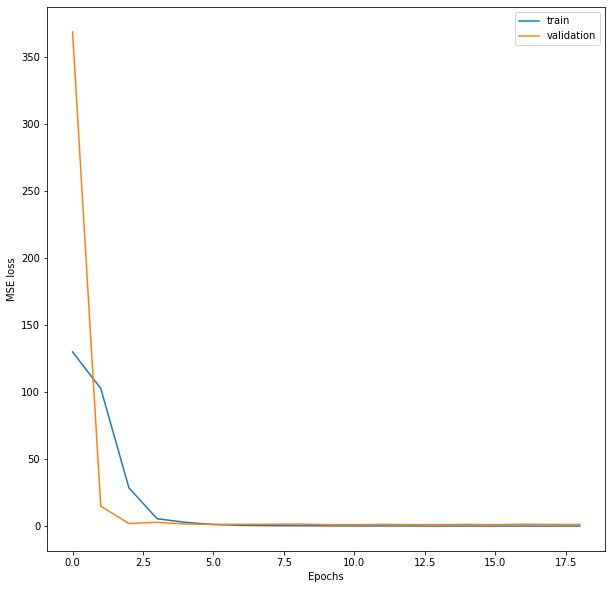

In [38]:
parameterization = {}
train = SalDataset(train_X, train_y)
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size= parameterization.get('batchsize', 8),
                                          drop_last=True,
                                          shuffle=False)

#train_loader = torch.utils.data.DataLoader(train,batch_size=8,drop_last=True,shuffle=False)
#val = SalDataset(val_X, val_y)
'''val_loader = torch.utils.data.DataLoader(val,
                                       batch_size=parameterization.get('batchsize', 8),
                                       drop_last=True,
                                       shuffle=False)'''
test = SalDataset(test_X, test_y)
test_loader = torch.utils.data.DataLoader(test,
                                    batch_size=parameterization.get('batchsize', 8),
                                        drop_last=True,
                                        shuffle=False)

# Get neural net
untrained_net = init_net(parameterization)

# train
trained_net = net_train(net=untrained_net, train_loader=train_loader, val_loader=test_loader,
                            parameters=parameterization, dtype=dtype, device=device)

In [44]:
_, real, predictions, historical =evaluate(
        net=trained_net,
        test_loader=test_loader,
        dtype=dtype,
        device=device,
    )

## Visualization

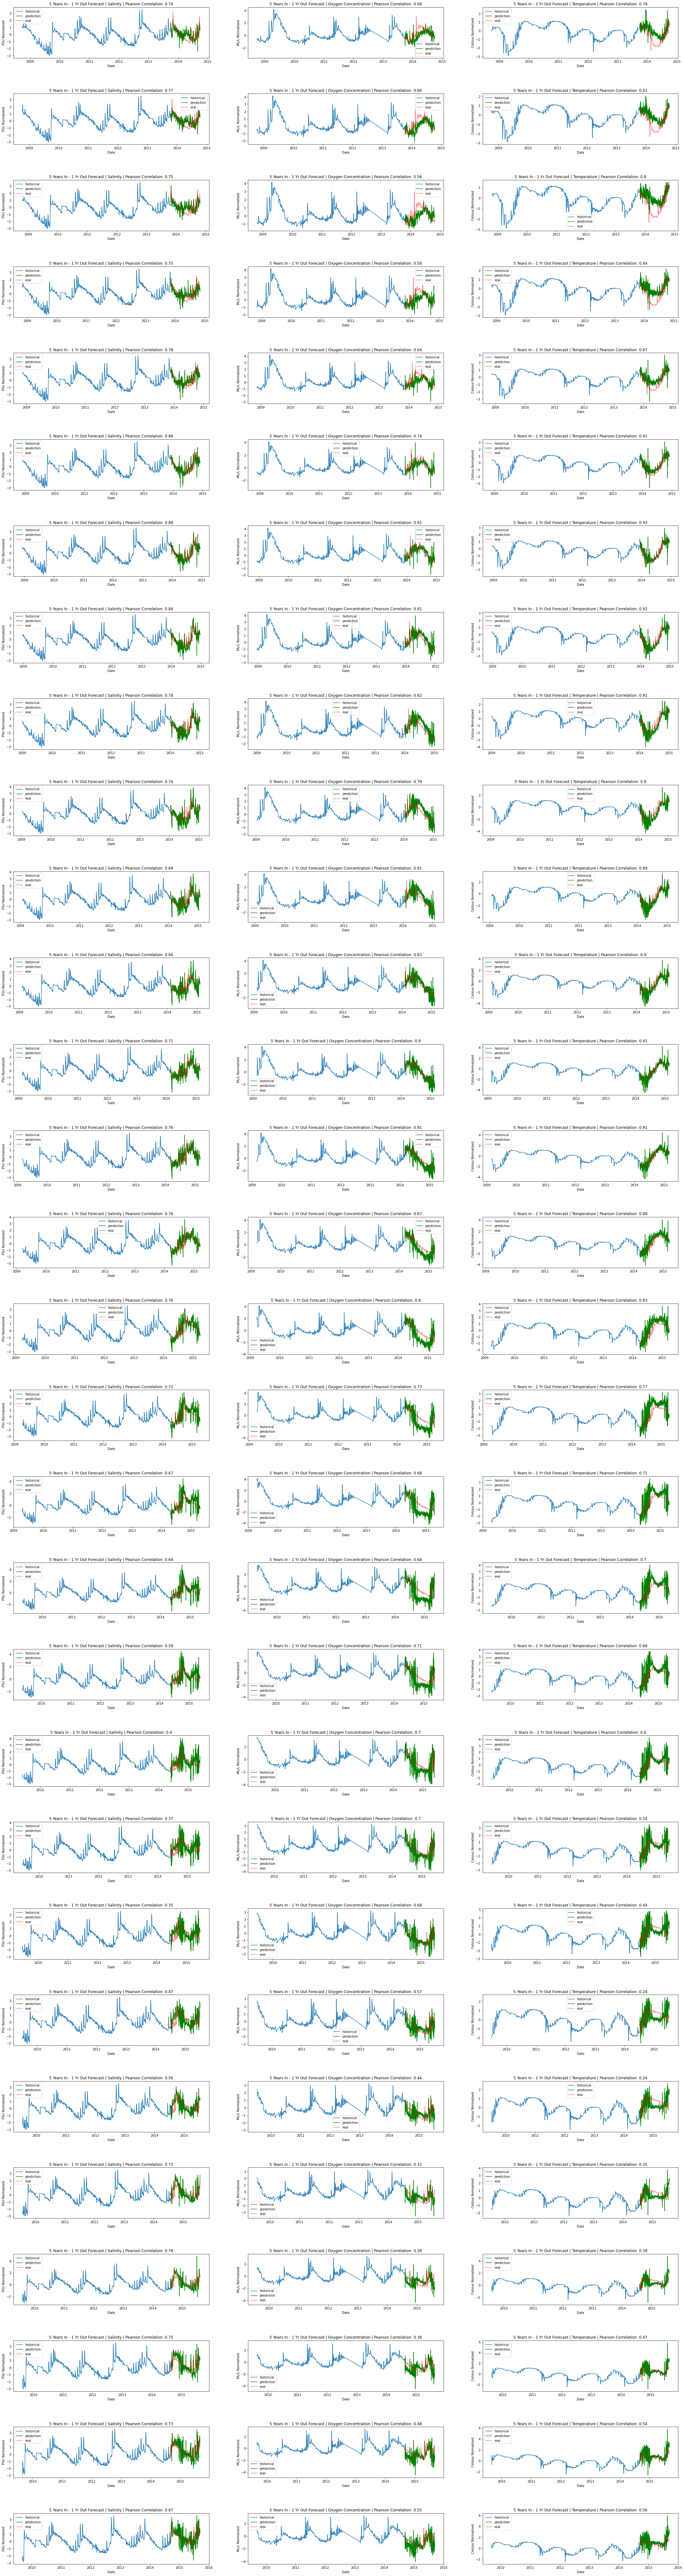

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(30, num_features,figsize=(38,150))
#fig, ax = plt.subplots(7, num_features,figsize=(38,60))
fig.subplots_adjust(hspace = .7, wspace=.2)

ax = ax.ravel()

year6 = out_length * 6
month = year6 / 72

titles = {0: '5 Years In - 1 Yr Out Forecast | Salinity',
              1: '5 Years In - 1 Yr Out Forecast | Oxygen Concentration',
              2: '5 Years In - 1 Yr Out Forecast | Temperature',
              3: '5 Years In - 1 Yr Out Forecast | Pressure'}
ylabel = {0: 'PSU Normalized',
          1: 'ML/L Normalized',
          2: 'Celsius Normalized',
          3: 'Decibar Normalized'}

batchsize = 8
test_start_date = signal_test.index[0]
test_start_date = signal_train.index[0]
offset = pd.DateOffset(hours= batchsize * hour_freq)

df_plot = df_all.loc[:,['PSU', 'ML_L', 'Celsius']]

#df_plot = pd.DataFrame(data_norm(df_plot.to_numpy()), columns= ['PSU', 'ML_L', 'Celsius'], index=index) 

for i in range(0,90,num_features):
  for n in range(0,num_features):
    
    h = pd.Series(historical[i][0,n,:].detach().cpu())
    p = pd.Series(predictions[i][0,:,n].detach().cpu())
    r = pd.Series(real[i][0,:,n].detach().cpu())

    pearson_corr = pd.concat([p, r], axis=1).corr('pearson').iloc[0,1]
    
    hp = h.append(p, ignore_index=True)
    hr = h.append(r, ignore_index=True)

    dates = pd.date_range(test_start_date + (offset * i), test_start_date + (offset * i) + pd.DateOffset(hours= len(hp) * 12 -1), freq=f'{hour_freq}H')

    hp.index = dates
    hr.index = dates

    ax[i+n].plot(hp.iloc[:len(h)], label='historical')
    
    ax[i+n].set_title(f'{titles[n]} | Pearson Correlation: {round(pearson_corr,2)}')
    #ax[i+n].set_xticks([0, month*12, month*24, month*36, month*48, month*60, year6])
    #ax[i+n].set_xticklabels(np.arange(0,73,12))
    ax[i+n].set_xlabel("Date")
    ax[i+n].set_ylabel(ylabel[n])
    ax[i+n].plot(hp.iloc[len(h):], color = 'g', label='prediction')
    ax[i+n].plot(hr.iloc[len(h):], color = 'r', label='real', alpha=0.55)
    #ax[i+n].plot(df_plot.loc[dates,df_plot.columns[n]] + 10, color = 'gray', alpha=0.5)
    ax[i+n].legend()

plt.show()

In [ ]:
pd.DataFrame(data_norm(df_all.to_numpy()), columns= ['PSU', 'ML_L', 'Celsius'], index=index)

PSU      ML_L   Celsius
2008-09-24 21:30:00 -0.510316  0.722030 -0.562221
2008-09-24 22:30:00 -0.504685  0.697312 -0.568542
2008-09-24 23:30:00 -0.513719  0.690157 -0.573178
2008-09-25 00:30:00 -0.486430  0.595241 -0.592713
2008-09-25 01:30:00 -0.483183  0.553301 -0.601771
...                       ...       ...       ...
2021-08-15 09:30:00 -0.496865  0.190468  0.187229
2021-08-15 10:30:00 -0.496865  0.190468  0.187229
2021-08-15 11:30:00 -0.496865  0.190468  0.187229
2021-08-15 12:30:00 -0.496865  0.190468  0.187229
2021-08-15 13:30:00 -0.496865  0.190468  0.187229

[112985 rows x 3 columns]

In [ ]:
df_plot.columns[0]

'PSU'

In [ ]:
dates[-1]

Timestamp('2021-03-17 21:30:00', freq='12H')

In [ ]:
df_resid_mean.tail()

ML_L       PSU   Celsius                Time
2021-03-27 21:30:00  0.026370 -0.004337 -0.016302 2021-03-27 21:30:00
2021-03-28 09:30:00 -0.028673  0.004878  0.019061 2021-03-28 09:30:00
2021-03-28 21:30:00  0.000000  0.000000  0.000000 2021-03-28 21:30:00
2021-03-29 09:30:00  0.000000  0.000000  0.000000 2021-03-29 09:30:00
2021-03-29 21:30:00  0.000000  0.000000  0.000000 2021-03-29 21:30:00

In [ ]:
hist_df = pd.DataFrame(historical[i][0,:,:].detach().cpu().numpy().T, columns=['PSU', 'ML_L', 'Celsius'])
real_df = pd.DataFrame(real[i][0,:,:].detach().cpu().numpy(), columns=['PSU', 'ML_L', 'Celsius'])

In [ ]:
match_df = hist_df.append(real_df, ignore_index=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f785e0158d0>,
      dtype=object)

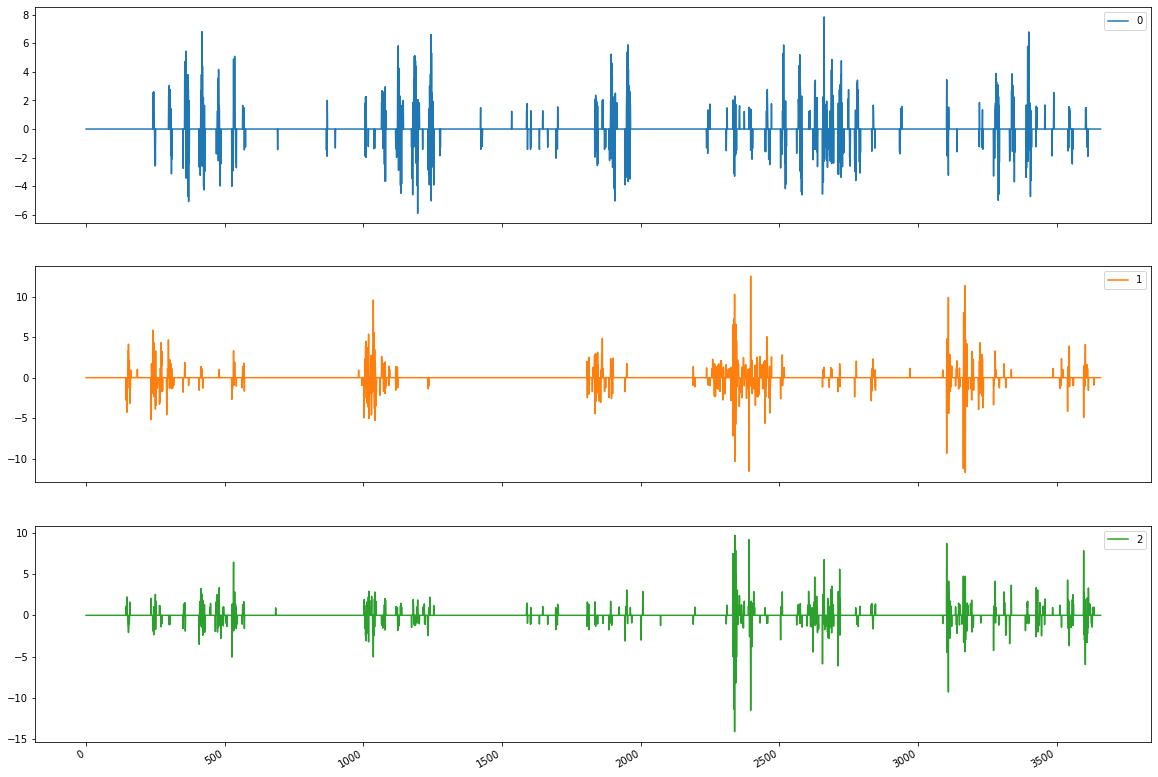

In [ ]:
pd.DataFrame(historical[0][0,:,:].detach().cpu().numpy().T).plot(subplots=True, figsize=(20,15))

In [ ]:
signal_test.index.values[0]

numpy.datetime64('2015-01-01T09:30:00.000000000')

In [ ]:
batchsize = 8
test_start_date = signal_test.index[0]
offset = pd.DateOffset(hours=batchsize*12)

plot_length = pd.date_range(test_start_date, freq=f'{hour_freq}H', periods = len(h) + len(r))



test_start_date + offset * (i + 1)

Timestamp('2015-01-09 09:30:00', freq='12H')

In [ ]:
len(hr)

4392

In [ ]:
pd.Series(historical[20][0,n,:].detach().cpu()).tail(50)

In [ ]:
pd.Series(historical[19][0,n,:].detach().cpu()).tail(50)

3610    0.005599
3611    0.005599
3612    0.005599
3613    0.005599
3614    0.005599
3615    0.005599
3616    0.005599
3617    0.005599
3618    0.005599
3619    0.005599
3620    0.005599
3621    0.005599
3622    0.005599
3623    0.005599
3624    0.005599
3625    0.005599
3626    0.005599
3627    0.005599
3628    0.005599
3629    1.864910
3630   -2.650963
3631    5.463124
3632   -6.581038
3633    2.594213
3634   -2.679660
3635   -3.644664
3636    1.442233
3637   -7.178252
3638    6.576472
3639   -3.607065
3640    3.069329
3641    1.575649
3642    1.384238
3643    1.450675
3644    0.005599
3645    0.005599
3646    0.005599
3647    0.005599
3648    0.005599
3649    0.005599
3650    0.005599
3651    0.005599
3652    0.005599
3653    0.005599
3654    0.005599
3655    0.005599
3656    0.005599
3657    0.005599
3658    0.005599
3659    6.031684
dtype: float64

In [ ]:
pd.Series(real[i][0,:,n].detach().cpu()).tail()

727    0.005599
728    0.005599
729    0.005599
730    0.005599
731    0.005599
dtype: float64